Feature engineering and analysis notebook
,loads patient composition data and creates new features
,analyzes feature importance and correlations
,creates visualizations to understand which features matter most
,selects best features for prediction


In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# try to import xgboost, install if not available
try:
    import xgboost
except ImportError:
    print("installing xgboost...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost", "-q"])
    import xgboost
    print("xgboost installed successfully")

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


In [79]:
# helper functions for model evaluation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    precision_recall_curve
)
from sklearn.base import clone

def evaluate_binary_model_cv(
    model,
    X,
    y,
    n_splits=5,
    random_state=42,
    plot_curves=True,
    verbose=True,
):
    """
    evaluate a binary classifier using stratified k-fold cv
    computes global confusion matrix + global roc/pr curves
    """

    X = np.asarray(X)
    y = np.asarray(y)

    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    metrics_per_fold = {
        "accuracy": [],
        "balanced_accuracy": [],
        "precision": [],
        "recall": [],
        "f1": [],
        "roc_auc": [],
        "pr_auc": [],
    }

    all_y_true = []
    all_y_pred = []
    all_y_score = []

    for fold_idx, (train_idx, test_idx) in enumerate(skf.split(X, y), start=1):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        clf = clone(model)
        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        if hasattr(clf, "predict_proba"):
            y_score = clf.predict_proba(X_test)[:, 1]
        elif hasattr(clf, "decision_function"):
            y_score = clf.decision_function(X_test)
        else:
            y_score = None

        acc = accuracy_score(y_test, y_pred)
        bacc = balanced_accuracy_score(y_test, y_pred)
        prec = precision_score(y_test, y_pred, zero_division=0)
        rec = recall_score(y_test, y_pred, zero_division=0)
        f1 = f1_score(y_test, y_pred, zero_division=0)

        metrics_per_fold["accuracy"].append(acc)
        metrics_per_fold["balanced_accuracy"].append(bacc)
        metrics_per_fold["precision"].append(prec)
        metrics_per_fold["recall"].append(rec)
        metrics_per_fold["f1"].append(f1)

        if y_score is not None and len(np.unique(y_test)) == 2:
            try:
                roc = roc_auc_score(y_test, y_score)
                pr = average_precision_score(y_test, y_score)
            except ValueError:
                roc, pr = np.nan, np.nan
        else:
            roc, pr = np.nan, np.nan

        metrics_per_fold["roc_auc"].append(roc)
        metrics_per_fold["pr_auc"].append(pr)

        all_y_true.append(y_test)
        all_y_pred.append(y_pred)
        if y_score is not None:
            all_y_score.append(y_score)

        if verbose:
            print(f"\nfold {fold_idx}/{n_splits}")
            print(f"  accuracy:           {acc:.3f}")
            print(f"  balanced accuracy:  {bacc:.3f}")
            print(f"  precision:          {prec:.3f}")
            print(f"  recall:             {rec:.3f}")
            print(f"  f1-score:           {f1:.3f}")
            if not np.isnan(roc):
                print(f"  roc auc:            {roc:.3f}")
                print(f"  pr auc (avgprec):   {pr:.3f}")

    all_y_true = np.concatenate(all_y_true)
    all_y_pred = np.concatenate(all_y_pred)
    all_y_score = np.concatenate(all_y_score) if len(all_y_score) > 0 else None

    results = {}
    for m, vals in metrics_per_fold.items():
        vals = np.array(vals, dtype=float)
        results[m + "_per_fold"] = vals
        results[m + "_mean"] = np.nanmean(vals)
        results[m + "_std"] = np.nanstd(vals)

    if verbose:
        print("\nmean cv metrics across folds")
        for m in ["accuracy", "balanced_accuracy", "precision", "recall", "f1", "roc_auc", "pr_auc"]:
            print(f"{m:18s}: {results[m + '_mean']:.3f} ± {results[m + '_std']:.3f}")

    if verbose:
        print("\nconfusion matrix (all folds combined)")
        cm = confusion_matrix(all_y_true, all_y_pred)
        print(cm)
        print("\nclassification report")
        print(classification_report(all_y_true, all_y_pred, digits=3))

    if plot_curves and all_y_score is not None:
        fpr, tpr, _ = roc_curve(all_y_true, all_y_score)
        precs, recs, _ = precision_recall_curve(all_y_true, all_y_score)

        plt.figure(figsize=(10, 4))

        plt.subplot(1, 2, 1)
        plt.plot(fpr, tpr, label=f"auc = {results['roc_auc_mean']:.3f}")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("false positive rate")
        plt.ylabel("true positive rate")
        plt.title("global roc curve")
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(recs, precs, label=f"ap = {results['pr_auc_mean']:.3f}")
        plt.xlabel("recall")
        plt.ylabel("precision")
        plt.title("global precision–recall curve")
        plt.legend()

        plt.tight_layout()
        plt.show()

    return results

def extract_metrics_from_results(results):
    """
    extract metrics from evaluate_binary_model_cv results dictionary
    """
    return {
        'accuracy': results.get('accuracy_mean', np.nan),
        'accuracy_std': results.get('accuracy_std', np.nan),
        'balanced_accuracy': results.get('balanced_accuracy_mean', np.nan),
        'balanced_accuracy_std': results.get('balanced_accuracy_std', np.nan),
        'precision': results.get('precision_mean', np.nan),
        'precision_std': results.get('precision_std', np.nan),
        'recall': results.get('recall_mean', np.nan),
        'recall_std': results.get('recall_std', np.nan),
        'f1': results.get('f1_mean', np.nan),
        'f1_std': results.get('f1_std', np.nan),
        'roc_auc': results.get('roc_auc_mean', np.nan),
        'roc_auc_std': results.get('roc_auc_std', np.nan),
        'pr_auc': results.get('pr_auc_mean', np.nan),
        'pr_auc_std': results.get('pr_auc_std', np.nan),
    }


In [80]:
# generate pre-treatment patient data if needed
import os
pre_csv_path = "../patient_celltype_composition_pre.csv"

if not os.path.exists(pre_csv_path):
    print("pre CSV not found, generating from h5ad file...")
    try:
        import scanpy as sc
        scanpy_available = True
    except ImportError:
        print("scanpy not available, installing...")
        import subprocess
        import sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", "scanpy", "-q"])
        import scanpy as sc
        scanpy_available = True
    
    # load h5ad and filter for Pre timepoint
    adata_path = "../melanoma_scRNA_processed.h5ad"
    print(f"loading single-cell data from {adata_path}...")
    adata = sc.read(adata_path)
    
    # filter for Pre timepoint only
    adata_pre = adata[adata.obs["Timepoint"] == "Pre"].copy()
    print(f"filtered to Pre timepoint: {adata_pre.n_obs} cells")
    
    # compute patient composition for pre-treatment patients
    def compute_patient_composition(adata, patient_col="PatientID", celltype_col="pred_celltype", response_col="Response"):
        rows = []
        for pid, sub in adata.obs.groupby(patient_col):
            total = len(sub)
            if total == 0:
                continue
            row = {"PatientID": pid}
            type_counts = sub[celltype_col].value_counts(normalize=True)
            for ct, frac in type_counts.items():
                row[f"frac_{ct}"] = frac
            if "CD8_state" in sub.columns:
                row["CD8_memory_frac"] = np.mean(sub["CD8_state"] == "Memory_like")
                row["CD8_exhaust_frac"] = np.mean(sub["CD8_state"] == "Exhausted_like")
                row["CD8_mem_exh_ratio"] = row["CD8_memory_frac"] / (row["CD8_exhaust_frac"] + 1e-6)
            else:
                row["CD8_memory_frac"] = 0
                row["CD8_exhaust_frac"] = 0
                row["CD8_mem_exh_ratio"] = 0
            if response_col in sub.columns:
                row["Response"] = sub[response_col].iloc[0]
            rows.append(row)
        return pd.DataFrame(rows)
    
    patient_features_pre = compute_patient_composition(adata_pre)
    patient_features_pre.to_csv(pre_csv_path, index=False)
    print(f"saved pre-treatment patient features to {pre_csv_path}")
    print(f"pre-treatment patients: {len(patient_features_pre)} patients")
else:
    print(f"pre CSV already exists: {pre_csv_path}")


pre CSV already exists: ../patient_celltype_composition_pre.csv


In [81]:
data_path = "../patient_celltype_composition_pre.csv"
df = pd.read_csv(data_path)

print(f"loaded data: {df.shape[0]} patients, {df.shape[1]} columns")
print(f"\ncolumns: {list(df.columns)}")
print(f"\nresponse distribution:")
print(df['Response'].value_counts())
print(f"\nfirst few rows:")
df.head()


loaded data: 19 patients, 13 columns

columns: ['PatientID', 'frac_NK', 'frac_T_cells', 'frac_CD8_T', 'frac_CD4_T', 'frac_B_cells', 'frac_Dendritic', 'frac_Plasma', 'frac_Myeloid', 'CD8_memory_frac', 'CD8_exhaust_frac', 'CD8_mem_exh_ratio', 'Response']

response distribution:
Response
Non-responder    10
Responder         9
Name: count, dtype: int64

first few rows:


,PatientID,frac_NK,frac_T_cells,frac_CD8_T,frac_CD4_T,frac_B_cells,frac_Dendritic,frac_Plasma,frac_Myeloid,CD8_memory_frac,CD8_exhaust_frac,CD8_mem_exh_ratio,Response
0,P1,0.310044,0.253275,0.231441,0.087336,0.065502,0.039301,0.008734,0.004367,0.637555,0.362445,1.759031,Responder
1,P2,0.189911,0.160237,0.421365,0.094955,0.011869,0.002967,0.014837,0.103858,0.121662,0.878338,0.138513,Non-responder
2,P3,0.261224,0.342857,0.142857,0.085714,0.061224,0.028571,0.012245,0.065306,0.461224,0.538776,0.856059,Non-responder
3,P4,0.183280,0.135048,0.176849,0.109325,0.048232,0.032154,0.025723,0.289389,0.356913,0.643087,0.554999,Non-responder
4,P6,0.038194,0.086806,0.083333,0.187500,0.045139,0.045139,0.385417,0.128472,0.267361,0.732639,0.364928,Non-responder


In [82]:
print("basic statistics by response:")
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != 'PatientID']

print(f"\nnumeric features: {len(numeric_cols)}")
print(numeric_cols)

df.groupby('Response')[numeric_cols].describe()


basic statistics by response:

numeric features: 11
['frac_NK', 'frac_T_cells', 'frac_CD8_T', 'frac_CD4_T', 'frac_B_cells', 'frac_Dendritic', 'frac_Plasma', 'frac_Myeloid', 'CD8_memory_frac', 'CD8_exhaust_frac', 'CD8_mem_exh_ratio']


frac_NK                                                    \
                count      mean       std       min       25%       50%   
Response                                                                  
Non-responder    10.0  0.208441  0.105080  0.038194  0.169175  0.192479   
Responder         9.0  0.119675  0.104222  0.022124  0.055215  0.086957   

                                  frac_T_cells            ...  \
                    75%       max        count      mean  ...   
Response                                                  ...   
Non-responder  0.255009  0.404558         10.0  0.211667  ...   
Responder      0.166172  0.310044          9.0  0.306297  ...   

              CD8_exhaust_frac           CD8_mem_exh_ratio            \
                           75%       max             count      mean   
Response                                                               
Non-responder         0.757284  0.878338              10.0  0.437018   
Responder             0.411765  0.668712               9.0  1.638906   

                                                                           
                    std       min       25%       50%       75%       max  
Response                                                                   
Non-responder  0.221010  0.138513  0.320985  0.415460  0.539552  0.856059  
Responder      0.580194  0.495412  1.428568  1.759031  2.013327  2.432981  

[2 rows x 88 columns]

In [83]:
print("creating new engineered features...")

df_eng = df.copy()

# total immune cell fraction (sum of all cell types)
celltype_cols = [c for c in df_eng.columns if c.startswith('frac_')]
df_eng['total_immune_frac'] = df_eng[celltype_cols].sum(axis=1)

# t cell related ratios
df_eng['cd8_cd4_ratio'] = df_eng['frac_CD8_T'] / (df_eng['frac_CD4_T'] + 1e-6)
df_eng['cd8_total_t_ratio'] = df_eng['frac_CD8_T'] / (df_eng['frac_T_cells'] + 1e-6)

# lymphoid vs myeloid balance
lymphoid_cols = ['frac_CD8_T', 'frac_CD4_T', 'frac_T_cells', 'frac_B_cells', 'frac_Plasma', 'frac_NK']
myeloid_cols = ['frac_Myeloid', 'frac_Dendritic']
df_eng['lymphoid_frac'] = df_eng[[c for c in lymphoid_cols if c in df_eng.columns]].sum(axis=1)
df_eng['myeloid_frac'] = df_eng[[c for c in myeloid_cols if c in df_eng.columns]].sum(axis=1)
df_eng['lymphoid_myeloid_ratio'] = df_eng['lymphoid_frac'] / (df_eng['myeloid_frac'] + 1e-6)

# cd8 state dominance
df_eng['cd8_state_dominance'] = df_eng['CD8_memory_frac'] - df_eng['CD8_exhaust_frac']

# effector vs regulatory balance (simplified)
df_eng['effector_frac'] = df_eng['frac_CD8_T'] + df_eng['frac_NK']
df_eng['effector_regulatory_ratio'] = df_eng['effector_frac'] / (df_eng['frac_CD4_T'] + 1e-6)

print(f"created {len(df_eng.columns) - len(df.columns)} new features")
print(f"total features now: {len(df_eng.columns)}")

new_features = [c for c in df_eng.columns if c not in df.columns]
print(f"\nnew features: {new_features}")

df_eng.head()


creating new engineered features...
created 9 new features
total features now: 22

new features: ['total_immune_frac', 'cd8_cd4_ratio', 'cd8_total_t_ratio', 'lymphoid_frac', 'myeloid_frac', 'lymphoid_myeloid_ratio', 'cd8_state_dominance', 'effector_frac', 'effector_regulatory_ratio']


,PatientID,frac_NK,frac_T_cells,frac_CD8_T,frac_CD4_T,frac_B_cells,frac_Dendritic,frac_Plasma,frac_Myeloid,CD8_memory_frac,...,Response,total_immune_frac,cd8_cd4_ratio,cd8_total_t_ratio,lymphoid_frac,myeloid_frac,lymphoid_myeloid_ratio,cd8_state_dominance,effector_frac,effector_regulatory_ratio
0,P1,0.310044,0.253275,0.231441,0.087336,0.065502,0.039301,0.008734,0.004367,0.637555,...,Responder,1.0,2.649970,0.913789,0.956332,0.043668,21.899499,0.275109,0.541485,6.199929
1,P2,0.189911,0.160237,0.421365,0.094955,0.011869,0.002967,0.014837,0.103858,0.121662,...,Non-responder,1.0,4.437453,2.629613,0.893175,0.106825,8.361033,-0.756677,0.611276,6.437432
2,P3,0.261224,0.342857,0.142857,0.085714,0.061224,0.028571,0.012245,0.065306,0.461224,...,Non-responder,1.0,1.666647,0.416665,0.906122,0.093878,9.652071,-0.077551,0.404082,4.714231
3,P4,0.183280,0.135048,0.176849,0.109325,0.048232,0.032154,0.025723,0.289389,0.356913,...,Non-responder,1.0,1.617632,1.309514,0.678457,0.321543,2.109993,-0.286174,0.360129,3.294088
4,P6,0.038194,0.086806,0.083333,0.187500,0.045139,0.045139,0.385417,0.128472,0.267361,...,Non-responder,1.0,0.444442,0.959989,0.826389,0.173611,4.759973,-0.465278,0.121528,0.648145


In [84]:
# prepare x and y
feature_cols = [c for c in df_eng.columns if c not in ['PatientID', 'Response']]
X = df_eng[feature_cols].copy()
y = (df_eng['Response'] == 'Responder').astype(int)

print(f"feature matrix shape: {X.shape}")
print(f"target distribution: {y.value_counts().to_dict()}")
print(f"\nfeature list:")
for i, feat in enumerate(feature_cols, 1):
    print(f"{i:2d}. {feat}")


feature matrix shape: (19, 20)
target distribution: {0: 10, 1: 9}

feature list:
 1. frac_NK
 2. frac_T_cells
 3. frac_CD8_T
 4. frac_CD4_T
 5. frac_B_cells
 6. frac_Dendritic
 7. frac_Plasma
 8. frac_Myeloid
 9. CD8_memory_frac
10. CD8_exhaust_frac
11. CD8_mem_exh_ratio
12. total_immune_frac
13. cd8_cd4_ratio
14. cd8_total_t_ratio
15. lymphoid_frac
16. myeloid_frac
17. lymphoid_myeloid_ratio
18. cd8_state_dominance
19. effector_frac
20. effector_regulatory_ratio


computing correlation matrix...


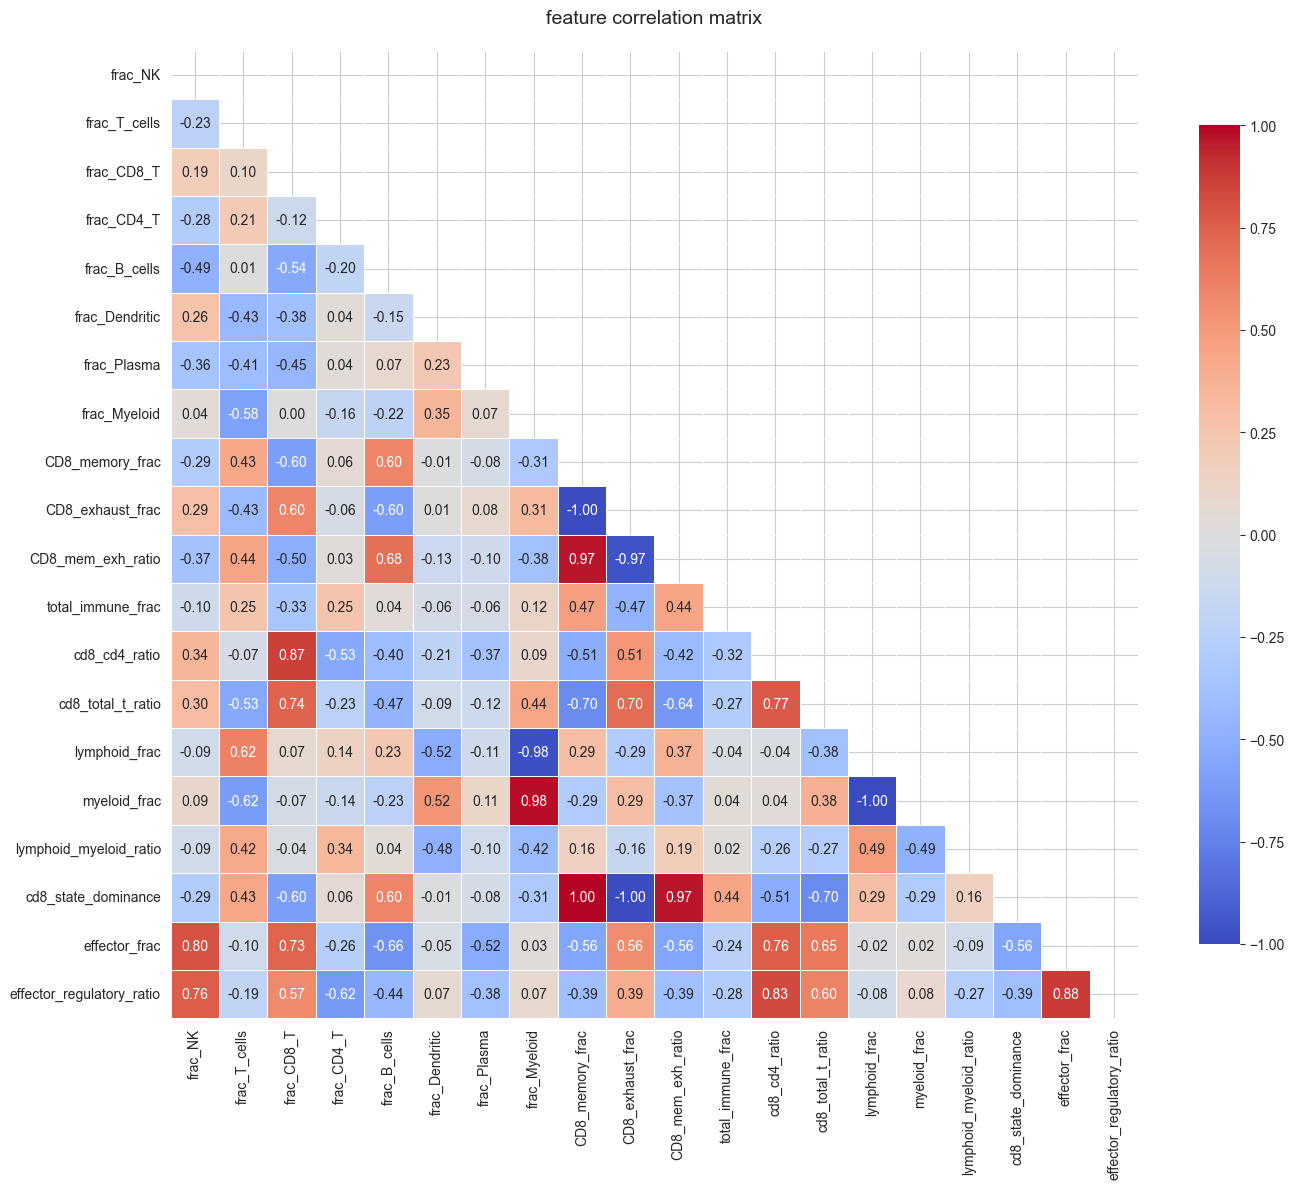


highly correlated feature pairs (|r| > 0.8):
  frac_NK <-> effector_frac: 0.804
  frac_CD8_T <-> cd8_cd4_ratio: 0.866
  frac_Myeloid <-> lymphoid_frac: -0.981
  frac_Myeloid <-> myeloid_frac: 0.981
  CD8_memory_frac <-> CD8_exhaust_frac: -1.000
  CD8_memory_frac <-> CD8_mem_exh_ratio: 0.967
  CD8_memory_frac <-> cd8_state_dominance: 1.000
  CD8_exhaust_frac <-> CD8_mem_exh_ratio: -0.967
  CD8_exhaust_frac <-> cd8_state_dominance: -1.000
  CD8_mem_exh_ratio <-> cd8_state_dominance: 0.967
  cd8_cd4_ratio <-> effector_regulatory_ratio: 0.832
  lymphoid_frac <-> myeloid_frac: -1.000
  effector_frac <-> effector_regulatory_ratio: 0.876


In [85]:
print("computing correlation matrix...")

corr_matrix = X.corr()

plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title('feature correlation matrix', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# find highly correlated pairs
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

if high_corr_pairs:
    print("\nhighly correlated feature pairs (|r| > 0.8):")
    for feat1, feat2, corr_val in high_corr_pairs:
        print(f"  {feat1} <-> {feat2}: {corr_val:.3f}")
else:
    print("\nno highly correlated pairs found (threshold: 0.8)")


correlation with target (response):


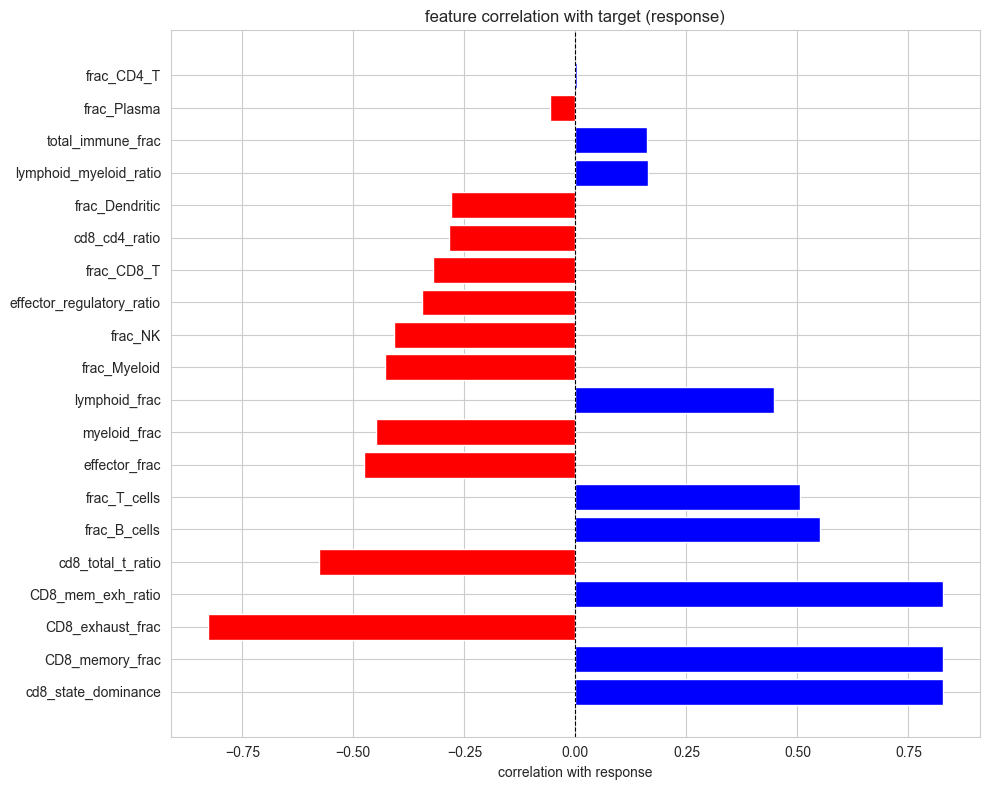


top 10 features by absolute correlation:
            feature  correlation  abs_correlation
cd8_state_dominance     0.828302         0.828302
    CD8_memory_frac     0.828302         0.828302
   CD8_exhaust_frac    -0.828302         0.828302
  CD8_mem_exh_ratio     0.828226         0.828226
  cd8_total_t_ratio    -0.577943         0.577943
       frac_B_cells     0.551854         0.551854
       frac_T_cells     0.505823         0.505823
      effector_frac    -0.476733         0.476733
       myeloid_frac    -0.447929         0.447929
      lymphoid_frac     0.447929         0.447929


In [86]:
print("correlation with target (response):")

target_corr = []
for col in X.columns:
    corr_val = X[col].corr(y)
    target_corr.append({'feature': col, 'correlation': corr_val, 'abs_correlation': abs(corr_val)})

target_corr_df = pd.DataFrame(target_corr).sort_values('abs_correlation', ascending=False)

plt.figure(figsize=(10, 8))
colors = ['red' if x < 0 else 'blue' for x in target_corr_df['correlation']]
plt.barh(range(len(target_corr_df)), target_corr_df['correlation'], color=colors)
plt.yticks(range(len(target_corr_df)), target_corr_df['feature'])
plt.xlabel('correlation with response')
plt.title('feature correlation with target (response)')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)
plt.tight_layout()
plt.show()

print("\ntop 10 features by absolute correlation:")
print(target_corr_df.head(10).to_string(index=False))


In [87]:
print("performing statistical tests (mann-whitney u test)...")

stat_results = []
for col in X.columns:
    responder_vals = X[y == 1][col].values
    nonresponder_vals = X[y == 0][col].values
    
    stat, pval = stats.mannwhitneyu(responder_vals, nonresponder_vals, alternative='two-sided')
    
    stat_results.append({
        'feature': col,
        'statistic': stat,
        'pvalue': pval,
        'responder_mean': responder_vals.mean(),
        'nonresponder_mean': nonresponder_vals.mean(),
        'mean_diff': responder_vals.mean() - nonresponder_vals.mean()
    })

stat_df = pd.DataFrame(stat_results).sort_values('pvalue')

print(f"\nfeatures with significant difference (p < 0.05):")
significant = stat_df[stat_df['pvalue'] < 0.05]
print(significant[['feature', 'pvalue', 'responder_mean', 'nonresponder_mean', 'mean_diff']].to_string(index=False))

print(f"\nfeatures with highly significant difference (p < 0.01):")
highly_sig = stat_df[stat_df['pvalue'] < 0.01]
print(highly_sig[['feature', 'pvalue', 'responder_mean', 'nonresponder_mean', 'mean_diff']].to_string(index=False))


performing statistical tests (mann-whitney u test)...

features with significant difference (p < 0.05):
            feature   pvalue  responder_mean  nonresponder_mean  mean_diff
       frac_B_cells 0.000520        0.161647           0.023913   0.137734
   CD8_exhaust_frac 0.000703        0.400487           0.710578  -0.310091
cd8_state_dominance 0.000703        0.199025          -0.421157   0.620182
    CD8_memory_frac 0.000703        0.599513           0.289422   0.310091
  CD8_mem_exh_ratio 0.000703        1.638906           0.437018   1.201888
  cd8_total_t_ratio 0.010112        0.571024           1.252448  -0.681425
       frac_T_cells 0.030486        0.306297           0.211667   0.094630
      effector_frac 0.045455        0.296855           0.446473  -0.149618

features with highly significant difference (p < 0.01):
            feature   pvalue  responder_mean  nonresponder_mean  mean_diff
       frac_B_cells 0.000520        0.161647           0.023913   0.137734
   CD8_exhaust

computing random forest feature importance...


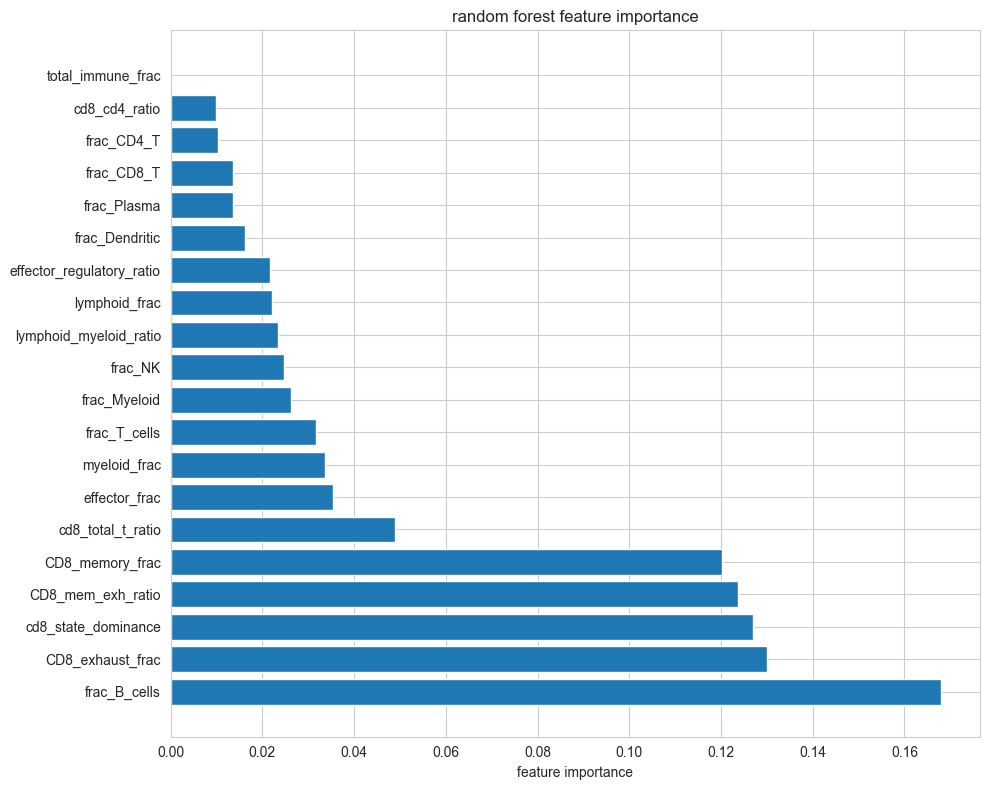


top 15 features by importance:
                  feature  importance
             frac_B_cells    0.168087
         CD8_exhaust_frac    0.130118
      cd8_state_dominance    0.126904
        CD8_mem_exh_ratio    0.123644
          CD8_memory_frac    0.120253
        cd8_total_t_ratio    0.048808
            effector_frac    0.035319
             myeloid_frac    0.033551
             frac_T_cells    0.031644
             frac_Myeloid    0.026212
                  frac_NK    0.024626
   lymphoid_myeloid_ratio    0.023468
            lymphoid_frac    0.022066
effector_regulatory_ratio    0.021751
           frac_Dendritic    0.016215


In [88]:
print("computing random forest feature importance...")

rf = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=42, max_depth=10)
rf.fit(X, y)

importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(range(len(importance_df)), importance_df['importance'])
plt.yticks(range(len(importance_df)), importance_df['feature'])
plt.xlabel('feature importance')
plt.title('random forest feature importance')
plt.tight_layout()
plt.show()

print("\ntop 15 features by importance:")
print(importance_df.head(15).to_string(index=False))


computing mutual information scores...


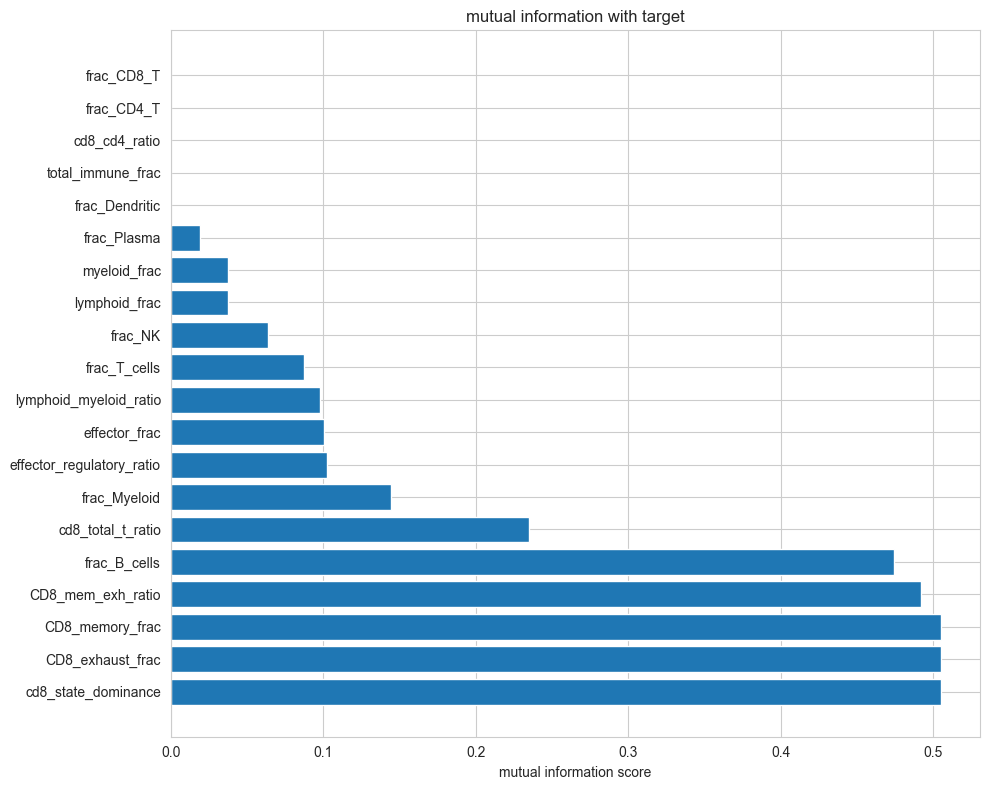


top 15 features by mutual information:
                  feature  mutual_info
      cd8_state_dominance     0.505445
         CD8_exhaust_frac     0.505445
          CD8_memory_frac     0.505445
        CD8_mem_exh_ratio     0.492287
             frac_B_cells     0.474242
        cd8_total_t_ratio     0.234851
             frac_Myeloid     0.144335
effector_regulatory_ratio     0.102731
            effector_frac     0.100476
   lymphoid_myeloid_ratio     0.098116
             frac_T_cells     0.087610
                  frac_NK     0.063860
            lymphoid_frac     0.037819
             myeloid_frac     0.037819
              frac_Plasma     0.018897


In [89]:
print("computing mutual information scores...")

mi_scores = mutual_info_classif(X, y, random_state=42)

mi_df = pd.DataFrame({
    'feature': X.columns,
    'mutual_info': mi_scores
}).sort_values('mutual_info', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(range(len(mi_df)), mi_df['mutual_info'])
plt.yticks(range(len(mi_df)), mi_df['feature'])
plt.xlabel('mutual information score')
plt.title('mutual information with target')
plt.tight_layout()
plt.show()

print("\ntop 15 features by mutual information:")
print(mi_df.head(15).to_string(index=False))


computing f-scores (anova f-statistic)...


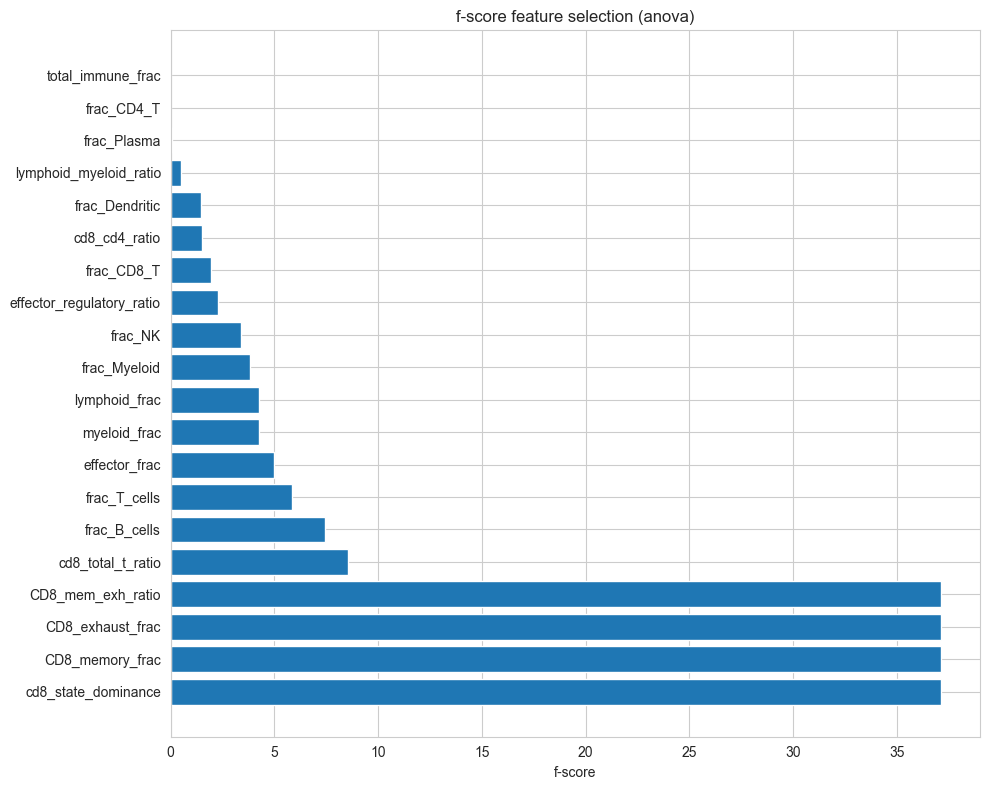


top 15 features by f-score:
                  feature   f_score   pvalue
      cd8_state_dominance 37.154507 0.000012
          CD8_memory_frac 37.154507 0.000012
         CD8_exhaust_frac 37.154507 0.000012
        CD8_mem_exh_ratio 37.133012 0.000012
        cd8_total_t_ratio  8.526238 0.009549
             frac_B_cells  7.444357 0.014299
             frac_T_cells  5.845061 0.027139
            effector_frac  5.000058 0.039044
             myeloid_frac  4.267012 0.054450
            lymphoid_frac  4.267012 0.054450
             frac_Myeloid  3.834805 0.066816
                  frac_NK  3.406253 0.082440
effector_regulatory_ratio  2.288559 0.148699
               frac_CD8_T  1.949803 0.180575
            cd8_cd4_ratio  1.509308 0.235982


In [90]:
print("computing f-scores (anova f-statistic)...")

f_selector = SelectKBest(score_func=f_classif, k='all')
f_selector.fit(X, y)

f_df = pd.DataFrame({
    'feature': X.columns,
    'f_score': f_selector.scores_,
    'pvalue': f_selector.pvalues_
}).sort_values('f_score', ascending=False)

plt.figure(figsize=(10, 8))
plt.barh(range(len(f_df)), f_df['f_score'])
plt.yticks(range(len(f_df)), f_df['feature'])
plt.xlabel('f-score')
plt.title('f-score feature selection (anova)')
plt.tight_layout()
plt.show()

print("\ntop 15 features by f-score:")
print(f_df.head(15).to_string(index=False))


creating combined feature ranking...


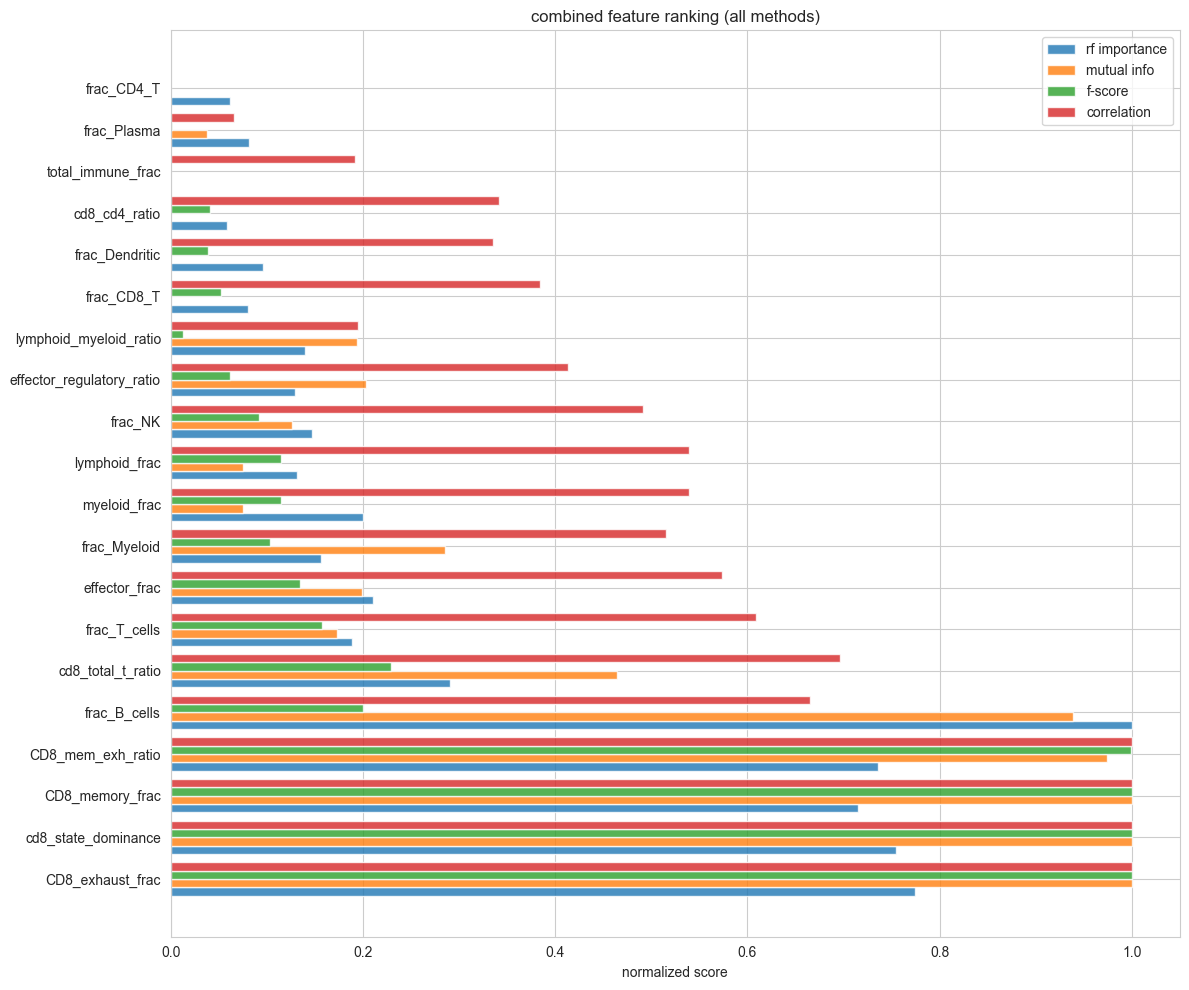


combined feature ranking:
                  feature  combined_score  importance_norm  mi_norm   f_norm  corr_norm
         CD8_exhaust_frac        0.943526         0.774108 0.999998 1.000000   0.999999
      cd8_state_dominance        0.938747         0.754989 0.999998 1.000000   0.999999
          CD8_memory_frac        0.928854         0.715419 0.999998 1.000000   0.999999
        CD8_mem_exh_ratio        0.927222         0.735592 0.973966 0.999421   0.999908
             frac_B_cells        0.700841         0.999994 0.938264 0.200362   0.664742
        cd8_total_t_ratio        0.420220         0.290374 0.464642 0.229481   0.696381
             frac_T_cells        0.281957         0.188260 0.173333 0.157318   0.608918
            effector_frac        0.279281         0.210122 0.198786 0.134575   0.573641
             frac_Myeloid        0.265123         0.155942 0.285561 0.103212   0.515776
             myeloid_frac        0.231995         0.199604 0.074823 0.114845   0.538708
     

In [91]:
print("creating combined feature ranking...")

# normalize all scores to 0-1 range
importance_df['importance_norm'] = (importance_df['importance'] - importance_df['importance'].min()) / (importance_df['importance'].max() - importance_df['importance'].min() + 1e-6)
mi_df['mi_norm'] = (mi_df['mutual_info'] - mi_df['mutual_info'].min()) / (mi_df['mutual_info'].max() - mi_df['mutual_info'].min() + 1e-6)
f_df['f_norm'] = (f_df['f_score'] - f_df['f_score'].min()) / (f_df['f_score'].max() - f_df['f_score'].min() + 1e-6)
target_corr_df['corr_norm'] = (target_corr_df['abs_correlation'] - target_corr_df['abs_correlation'].min()) / (target_corr_df['abs_correlation'].max() - target_corr_df['abs_correlation'].min() + 1e-6)

# combine rankings
combined = pd.DataFrame({'feature': X.columns})
combined = combined.merge(importance_df[['feature', 'importance_norm']], on='feature')
combined = combined.merge(mi_df[['feature', 'mi_norm']], on='feature')
combined = combined.merge(f_df[['feature', 'f_norm']], on='feature')
combined = combined.merge(target_corr_df[['feature', 'corr_norm']], on='feature')

# average normalized scores
combined['combined_score'] = (combined['importance_norm'] + combined['mi_norm'] + combined['f_norm'] + combined['corr_norm']) / 4
combined = combined.sort_values('combined_score', ascending=False)

plt.figure(figsize=(12, 10))
x_pos = np.arange(len(combined))
width = 0.2
plt.barh(x_pos - 1.5*width, combined['importance_norm'], width, label='rf importance', alpha=0.8)
plt.barh(x_pos - 0.5*width, combined['mi_norm'], width, label='mutual info', alpha=0.8)
plt.barh(x_pos + 0.5*width, combined['f_norm'], width, label='f-score', alpha=0.8)
plt.barh(x_pos + 1.5*width, combined['corr_norm'], width, label='correlation', alpha=0.8)
plt.yticks(x_pos, combined['feature'])
plt.xlabel('normalized score')
plt.title('combined feature ranking (all methods)')
plt.legend()
plt.tight_layout()
plt.show()

print("\ncombined feature ranking:")
print(combined[['feature', 'combined_score', 'importance_norm', 'mi_norm', 'f_norm', 'corr_norm']].to_string(index=False))


plotting feature distributions by response...


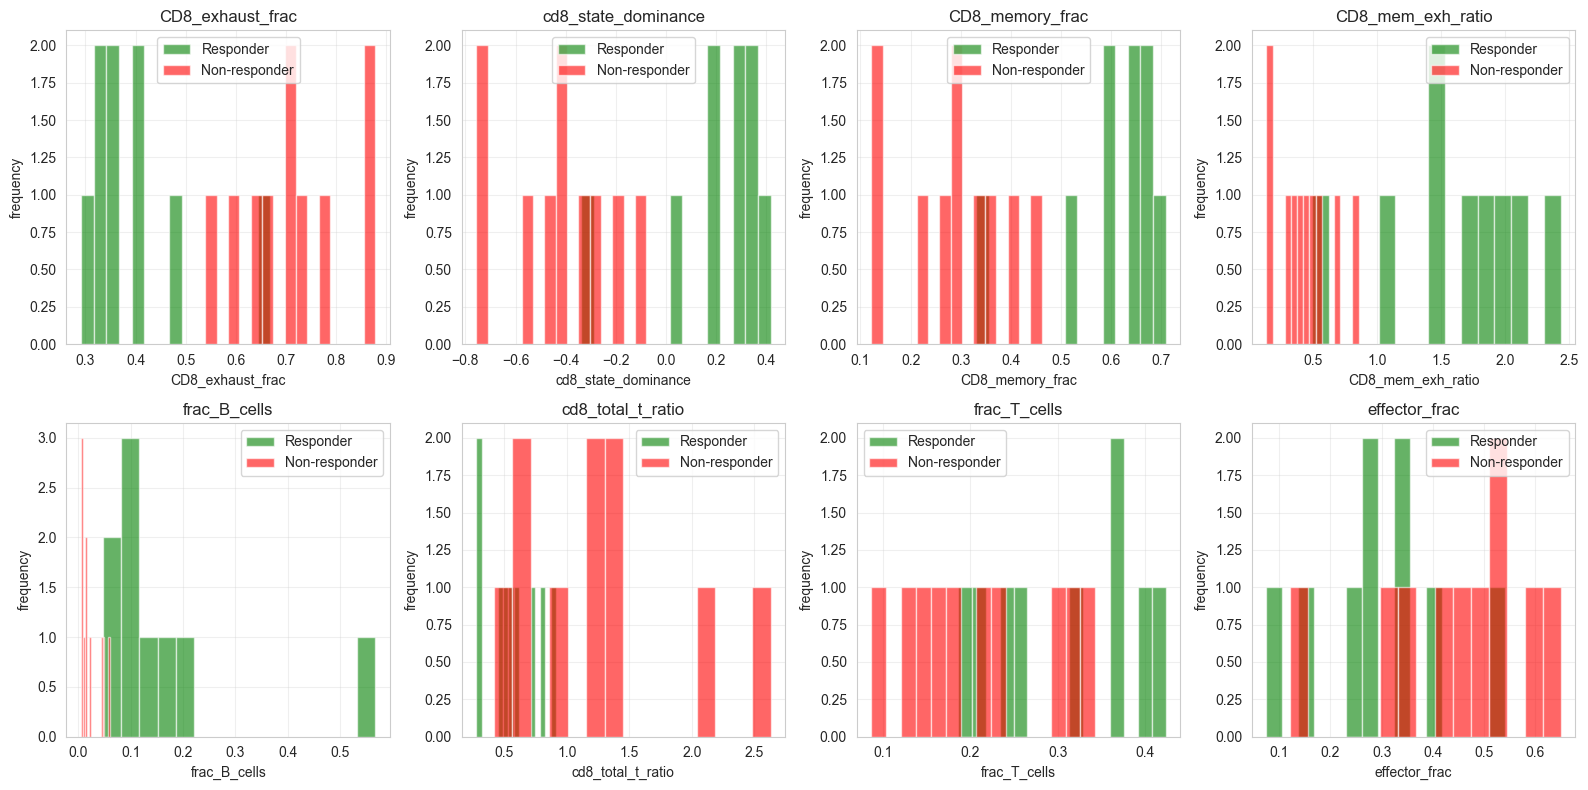

In [92]:
print("plotting feature distributions by response...")

# select top features for visualization
top_features = combined.head(8)['feature'].tolist()

n_cols = 4
n_rows = (len(top_features) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for idx, feat in enumerate(top_features):
    ax = axes[idx]
    
    responder_vals = df_eng[df_eng['Response'] == 'Responder'][feat]
    nonresponder_vals = df_eng[df_eng['Response'] == 'Non-responder'][feat]
    
    ax.hist(responder_vals, alpha=0.6, label='Responder', bins=15, color='green')
    ax.hist(nonresponder_vals, alpha=0.6, label='Non-responder', bins=15, color='red')
    ax.set_xlabel(feat)
    ax.set_ylabel('frequency')
    ax.set_title(feat)
    ax.legend()
    ax.grid(True, alpha=0.3)

# hide extra subplots
for idx in range(len(top_features), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()


creating boxplots for top features...


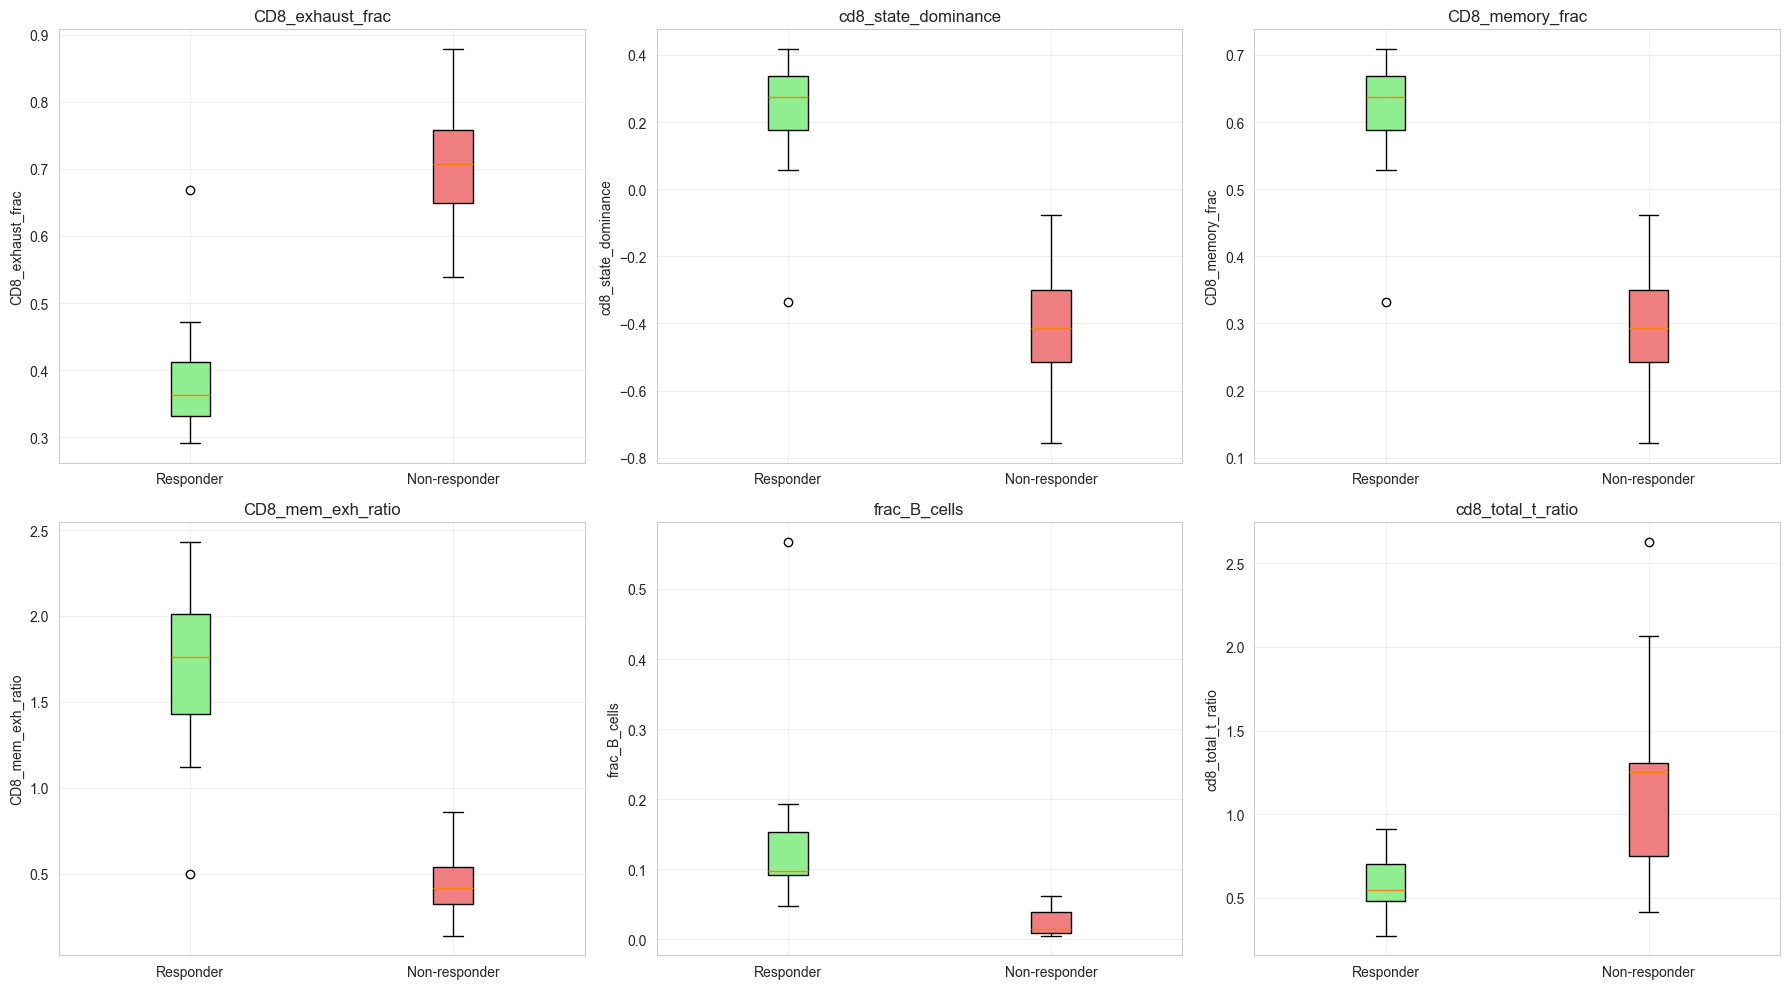

In [93]:
print("creating boxplots for top features...")

top_features = combined.head(6)['feature'].tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for idx, feat in enumerate(top_features):
    ax = axes[idx]
    
    data_to_plot = [
        df_eng[df_eng['Response'] == 'Responder'][feat].values,
        df_eng[df_eng['Response'] == 'Non-responder'][feat].values
    ]
    
    bp = ax.boxplot(data_to_plot, labels=['Responder', 'Non-responder'], patch_artist=True)
    bp['boxes'][0].set_facecolor('lightgreen')
    bp['boxes'][1].set_facecolor('lightcoral')
    
    ax.set_ylabel(feat)
    ax.set_title(feat)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


selecting best features based on combined ranking...

selected top 10 features:
 1. CD8_exhaust_frac               (score: 0.9435)
 2. cd8_state_dominance            (score: 0.9387)
 3. CD8_memory_frac                (score: 0.9289)
 4. CD8_mem_exh_ratio              (score: 0.9272)
 5. frac_B_cells                   (score: 0.7008)
 6. cd8_total_t_ratio              (score: 0.4202)
 7. frac_T_cells                   (score: 0.2820)
 8. effector_frac                  (score: 0.2793)
 9. frac_Myeloid                   (score: 0.2651)
10. myeloid_frac                   (score: 0.2320)

reduced feature matrix shape: (19, 10)

feature correlation matrix for selected features:


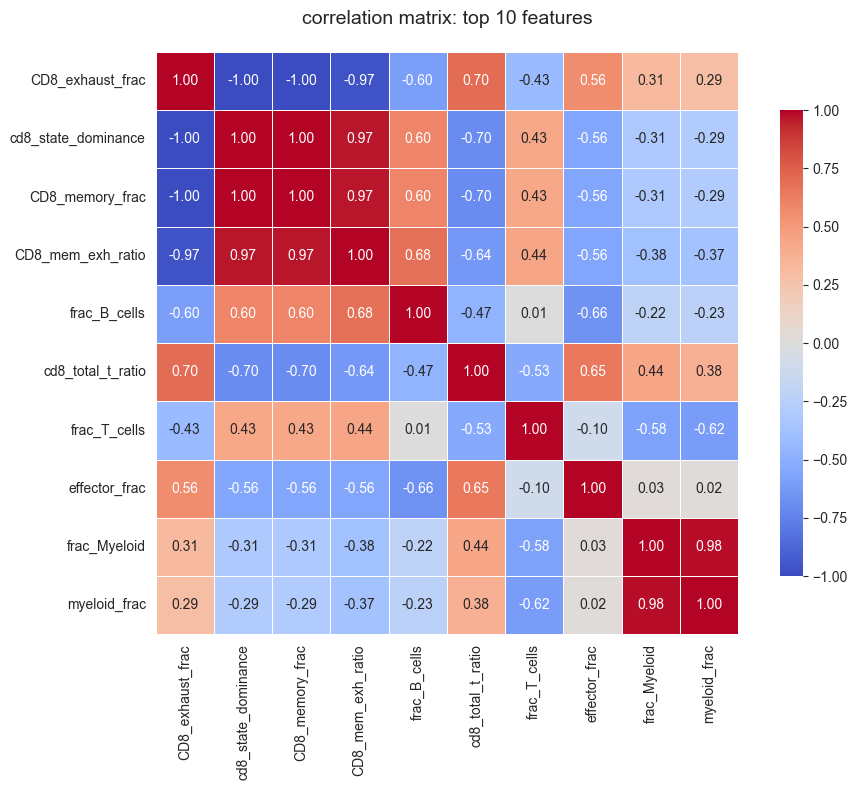


saved selected features to dataframe


,PatientID,Response,CD8_exhaust_frac,cd8_state_dominance,CD8_memory_frac,CD8_mem_exh_ratio,frac_B_cells,cd8_total_t_ratio,frac_T_cells,effector_frac,frac_Myeloid,myeloid_frac
0,P1,Responder,0.362445,0.275109,0.637555,1.759031,0.065502,0.913789,0.253275,0.541485,0.004367,0.043668
1,P2,Non-responder,0.878338,-0.756677,0.121662,0.138513,0.011869,2.629613,0.160237,0.611276,0.103858,0.106825
2,P3,Non-responder,0.538776,-0.077551,0.461224,0.856059,0.061224,0.416665,0.342857,0.404082,0.065306,0.093878
3,P4,Non-responder,0.643087,-0.286174,0.356913,0.554999,0.048232,1.309514,0.135048,0.360129,0.289389,0.321543
4,P6,Non-responder,0.732639,-0.465278,0.267361,0.364928,0.045139,0.959989,0.086806,0.121528,0.128472,0.173611


In [94]:
print("selecting best features based on combined ranking...")

# select top k features
k = 10
best_features = combined.head(k)['feature'].tolist()

print(f"\nselected top {k} features:")
for i, feat in enumerate(best_features, 1):
    score = combined[combined['feature'] == feat]['combined_score'].values[0]
    print(f"{i:2d}. {feat:30s} (score: {score:.4f})")

# create reduced feature set
X_selected = X[best_features].copy()

print(f"\nreduced feature matrix shape: {X_selected.shape}")
print(f"\nfeature correlation matrix for selected features:")

plt.figure(figsize=(10, 8))
corr_selected = X_selected.corr()
sns.heatmap(corr_selected, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title(f'correlation matrix: top {k} features', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

# save selected features
df_selected = df_eng[['PatientID', 'Response'] + best_features].copy()
print(f"\nsaved selected features to dataframe")
df_selected.head()


In [95]:
print("=== FEATURE ENGINEERING SUMMARY ===")
print(f"\noriginal features: {len(df.columns) - 2}")
print(f"engineered features: {len(df_eng.columns) - len(df.columns)}")
print(f"total features: {len(X.columns)}")
print(f"\nselected best features: {len(best_features)}")
print(f"\ntop 5 features by combined score:")
for i, row in combined.head(5).iterrows():
    print(f"  {row['feature']}: {row['combined_score']:.4f}")
print(f"\nfeatures with p < 0.05: {len(stat_df[stat_df['pvalue'] < 0.05])}")
print(f"features with p < 0.01: {len(stat_df[stat_df['pvalue'] < 0.01])}")


=== FEATURE ENGINEERING SUMMARY ===

original features: 11
engineered features: 9
total features: 20

selected best features: 10

top 5 features by combined score:
  CD8_exhaust_frac: 0.9435
  cd8_state_dominance: 0.9387
  CD8_memory_frac: 0.9289
  CD8_mem_exh_ratio: 0.9272
  frac_B_cells: 0.7008

features with p < 0.05: 8
features with p < 0.01: 5


In [96]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score, confusion_matrix, classification_report
import numpy as np

try:
    from xgboost import XGBClassifier
    xgboost_available = True
except ImportError:
    print("xgboost not found, attempting to install...")
    import subprocess
    import sys
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost", "-q"], 
                            stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        from xgboost import XGBClassifier
        xgboost_available = True
        print("xgboost installed and imported successfully")
    except:
        print("warning: xgboost not available, skipping xgboost model")
        xgboost_available = False

print("running ml models with best features...")
print(f"using top {len(best_features)} features: {best_features}")

# prepare data with selected features
X_best = X[best_features].copy()
y_best = y.copy()

print(f"\ndata shape: {X_best.shape}")
print(f"target distribution: {y_best.value_counts().to_dict()}")

# setup cross validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n" + "="*60)
print("MODEL 1: RANDOM FOREST")
print("="*60)

rf = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42)
rf_scores = cross_val_score(rf, X_best, y_best, cv=cv, scoring='accuracy')
rf_scores_balanced = cross_val_score(rf, X_best, y_best, cv=cv, scoring='balanced_accuracy')

print(f"accuracy: {rf_scores.mean():.4f} ± {rf_scores.std():.4f}")
print(f"balanced accuracy: {rf_scores_balanced.mean():.4f} ± {rf_scores_balanced.std():.4f}")

# fit on full data to get feature importance
rf.fit(X_best, y_best)
rf_importance = pd.DataFrame({
    'feature': best_features,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\ntop features by rf importance:")
print(rf_importance.to_string(index=False))

print("\n" + "="*60)
print("MODEL 2: LOGISTIC REGRESSION")
print("="*60)

lr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=500, penalty='l2', class_weight='balanced', random_state=42))
])

lr_scores = cross_val_score(lr_pipe, X_best, y_best, cv=cv, scoring='accuracy')
lr_scores_balanced = cross_val_score(lr_pipe, X_best, y_best, cv=cv, scoring='balanced_accuracy')

print(f"accuracy: {lr_scores.mean():.4f} ± {lr_scores.std():.4f}")
print(f"balanced accuracy: {lr_scores_balanced.mean():.4f} ± {lr_scores_balanced.std():.4f}")

# get coefficients
lr_pipe.fit(X_best, y_best)
lr_coef = pd.DataFrame({
    'feature': best_features,
    'coefficient': lr_pipe.named_steps['clf'].coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\ntop features by lr coefficient (absolute value):")
print(lr_coef.to_string(index=False))

if xgboost_available:
    print("\n" + "="*60)
    print("MODEL 3: XGBOOST")
    print("="*60)

    xgb = XGBClassifier(
        n_estimators=500,
        learning_rate=0.02,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss'
    )

    xgb_scores = cross_val_score(xgb, X_best, y_best, cv=cv, scoring='accuracy')
    xgb_scores_balanced = cross_val_score(xgb, X_best, y_best, cv=cv, scoring='balanced_accuracy')

    print(f"accuracy: {xgb_scores.mean():.4f} ± {xgb_scores.std():.4f}")
    print(f"balanced accuracy: {xgb_scores_balanced.mean():.4f} ± {xgb_scores_balanced.std():.4f}")

    # fit on full data to get feature importance
    xgb.fit(X_best, y_best)
    xgb_importance = pd.DataFrame({
        'feature': best_features,
        'importance': xgb.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\ntop features by xgb importance:")
    print(xgb_importance.to_string(index=False))
else:
    xgb_scores = None
    xgb_scores_balanced = None


running ml models with best features...
using top 10 features: ['CD8_exhaust_frac', 'cd8_state_dominance', 'CD8_memory_frac', 'CD8_mem_exh_ratio', 'frac_B_cells', 'cd8_total_t_ratio', 'frac_T_cells', 'effector_frac', 'frac_Myeloid', 'myeloid_frac']

data shape: (19, 10)
target distribution: {0: 10, 1: 9}

MODEL 1: RANDOM FOREST
accuracy: 0.9000 ± 0.1225
balanced accuracy: 0.9000 ± 0.1225

top features by rf importance:
            feature  importance
       frac_B_cells    0.220322
    CD8_memory_frac    0.164248
   CD8_exhaust_frac    0.159115
cd8_state_dominance    0.149596
  CD8_mem_exh_ratio    0.132757
       frac_T_cells    0.048663
  cd8_total_t_ratio    0.041371
      effector_frac    0.034071
       myeloid_frac    0.026377
       frac_Myeloid    0.023480

MODEL 2: LOGISTIC REGRESSION
accuracy: 0.8500 ± 0.2000
balanced accuracy: 0.8500 ± 0.2000

top features by lr coefficient (absolute value):
            feature  coefficient
       frac_B_cells     0.627142
  CD8_mem_exh_rati

comparing model performance...

model comparison:
              model  accuracy_mean  accuracy_std  balanced_accuracy_mean  balanced_accuracy_std
      Random Forest           0.90      0.122474                    0.90               0.122474
Logistic Regression           0.85      0.200000                    0.85               0.200000
            XGBoost           0.85      0.122474                    0.85               0.122474


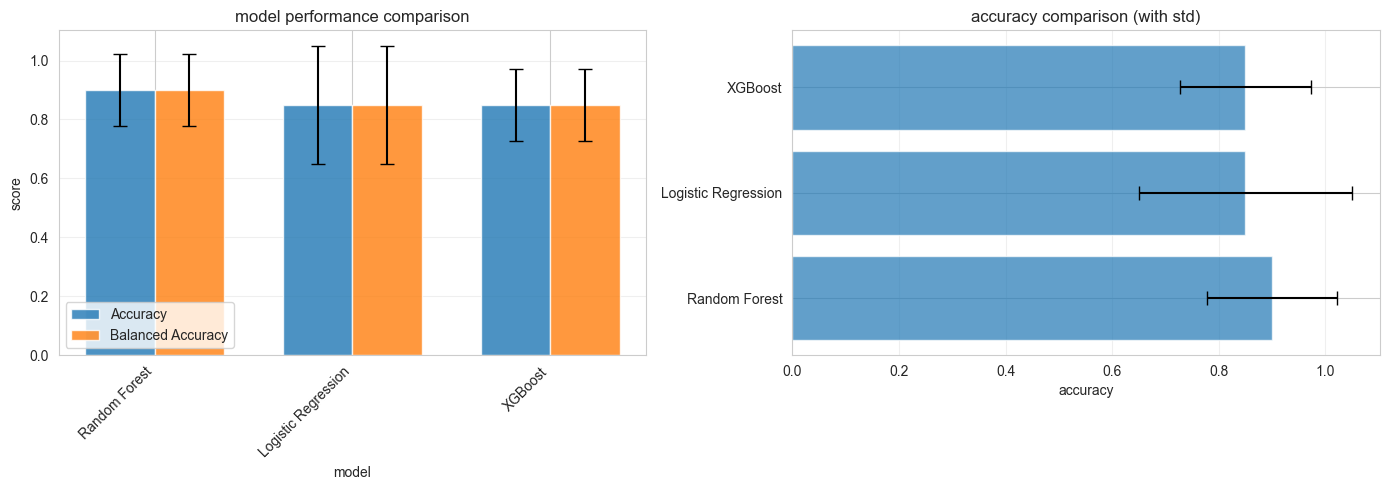


best model by accuracy: Random Forest
best model by balanced accuracy: Random Forest


In [97]:
print("comparing model performance...")

# safety check in case xgboost_available wasn't defined
if 'xgboost_available' not in locals():
    xgboost_available = False

if xgboost_available:
    results_df = pd.DataFrame({
        'model': ['Random Forest', 'Logistic Regression', 'XGBoost'],
        'accuracy_mean': [rf_scores.mean(), lr_scores.mean(), xgb_scores.mean()],
        'accuracy_std': [rf_scores.std(), lr_scores.std(), xgb_scores.std()],
        'balanced_accuracy_mean': [rf_scores_balanced.mean(), lr_scores_balanced.mean(), xgb_scores_balanced.mean()],
        'balanced_accuracy_std': [rf_scores_balanced.std(), lr_scores_balanced.std(), xgb_scores_balanced.std()]
    })
else:
    results_df = pd.DataFrame({
        'model': ['Random Forest', 'Logistic Regression'],
        'accuracy_mean': [rf_scores.mean(), lr_scores.mean()],
        'accuracy_std': [rf_scores.std(), lr_scores.std()],
        'balanced_accuracy_mean': [rf_scores_balanced.mean(), lr_scores_balanced.mean()],
        'balanced_accuracy_std': [rf_scores_balanced.std(), lr_scores_balanced.std()]
    })

print("\nmodel comparison:")
print(results_df.to_string(index=False))

# visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# accuracy comparison
x_pos = np.arange(len(results_df))
width = 0.35

axes[0].bar(x_pos - width/2, results_df['accuracy_mean'], width, yerr=results_df['accuracy_std'], 
            label='Accuracy', alpha=0.8, capsize=5)
axes[0].bar(x_pos + width/2, results_df['balanced_accuracy_mean'], width, yerr=results_df['balanced_accuracy_std'],
            label='Balanced Accuracy', alpha=0.8, capsize=5)
axes[0].set_xlabel('model')
axes[0].set_ylabel('score')
axes[0].set_title('model performance comparison')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(results_df['model'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# bar chart
axes[1].barh(results_df['model'], results_df['accuracy_mean'], xerr=results_df['accuracy_std'], 
             alpha=0.7, capsize=5)
axes[1].set_xlabel('accuracy')
axes[1].set_title('accuracy comparison (with std)')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"\nbest model by accuracy: {results_df.loc[results_df['accuracy_mean'].idxmax(), 'model']}")
print(f"best model by balanced accuracy: {results_df.loc[results_df['balanced_accuracy_mean'].idxmax(), 'model']}")


In [98]:
print("="*70)
print("COMPARISON: BEFORE vs AFTER FEATURE ENGINEERING")
print("="*70)

# original results from patient_comp_predictions.ipynb (base features only, 11 features)
original_results = {
    'Random Forest': {
        'accuracy': 0.7810,
        'accuracy_std': 0.0759,
        'recall': 0.5667,
        'recall_std': 0.0816,
        'balanced_accuracy': 0.7333,
        'balanced_accuracy_std': 0.0677
    },
    'Logistic Regression': {
        'accuracy': 0.7810,
        'accuracy_std': 0.1486,
        'recall': 0.6333,
        'recall_std': 0.1944,
        'balanced_accuracy': 0.7417,
        'balanced_accuracy_std': 0.1453
    },
    'XGBoost': {
        'accuracy': 0.8429,
        'accuracy_std': 0.0911,
        'recall': 0.6333,
        'recall_std': 0.1944,
        'balanced_accuracy': 0.7917,
        'balanced_accuracy_std': 0.1054
    }
}

# compute detailed metrics for new models (with best features)
print("\ncomputing detailed metrics for new models...")

def compute_detailed_metrics(model, X, y, cv):
    from sklearn.metrics import recall_score, precision_score, f1_score
    from sklearn.base import clone
    import numpy as np
    all_recall = []
    all_precision = []
    all_f1 = []
    
    # ensure X and y are numpy arrays
    X = np.asarray(X)
    y = np.asarray(y)
    
    for train_idx, test_idx in cv.split(X, y):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model_clone = clone(model)
        model_clone.fit(X_train, y_train)
        y_pred = model_clone.predict(X_test)
        
        all_recall.append(recall_score(y_test, y_pred, zero_division=0))
        all_precision.append(precision_score(y_test, y_pred, zero_division=0))
        all_f1.append(f1_score(y_test, y_pred, zero_division=0))
    
    return {
        'recall': np.mean(all_recall),
        'recall_std': np.std(all_recall),
        'precision': np.mean(all_precision),
        'precision_std': np.std(all_precision),
        'f1': np.mean(all_f1),
        'f1_std': np.std(all_f1)
    }

new_rf_metrics = compute_detailed_metrics(rf, X_best, y_best, cv)
new_lr_metrics = compute_detailed_metrics(lr_pipe, X_best, y_best, cv)

new_results = {
    'Random Forest': {
        'accuracy': rf_scores.mean(),
        'accuracy_std': rf_scores.std(),
        'recall': new_rf_metrics['recall'],
        'recall_std': new_rf_metrics['recall_std'],
        'balanced_accuracy': rf_scores_balanced.mean(),
        'balanced_accuracy_std': rf_scores_balanced.std()
    },
    'Logistic Regression': {
        'accuracy': lr_scores.mean(),
        'accuracy_std': lr_scores.std(),
        'recall': new_lr_metrics['recall'],
        'recall_std': new_lr_metrics['recall_std'],
        'balanced_accuracy': lr_scores_balanced.mean(),
        'balanced_accuracy_std': lr_scores_balanced.std()
    }
}

if xgboost_available:
    new_xgb_metrics = compute_detailed_metrics(xgb, X_best, y_best, cv)
    new_results['XGBoost'] = {
        'accuracy': xgb_scores.mean(),
        'accuracy_std': xgb_scores.std(),
        'recall': new_xgb_metrics['recall'],
        'recall_std': new_xgb_metrics['recall_std'],
        'balanced_accuracy': xgb_scores_balanced.mean(),
        'balanced_accuracy_std': xgb_scores_balanced.std()
    }

# create comparison dataframe
comparison_data = []
for model_name in ['Random Forest', 'Logistic Regression', 'XGBoost']:
    if model_name in original_results and (model_name in new_results or (model_name == 'XGBoost' and not xgboost_available)):
        if model_name == 'XGBoost' and not xgboost_available:
            continue
        comparison_data.append({
            'model': model_name,
            'before_accuracy': original_results[model_name]['accuracy'],
            'after_accuracy': new_results[model_name]['accuracy'],
            'accuracy_improvement': new_results[model_name]['accuracy'] - original_results[model_name]['accuracy'],
            'before_recall': original_results[model_name]['recall'],
            'after_recall': new_results[model_name]['recall'],
            'recall_improvement': new_results[model_name]['recall'] - original_results[model_name]['recall'],
            'before_balanced_acc': original_results[model_name]['balanced_accuracy'],
            'after_balanced_acc': new_results[model_name]['balanced_accuracy'],
            'balanced_acc_improvement': new_results[model_name]['balanced_accuracy'] - original_results[model_name]['balanced_accuracy']
        })

comparison_df = pd.DataFrame(comparison_data)

if len(comparison_df) == 0:
    print("warning: no models available for comparison")
else:
    print("\ncomparison table:")
    print(comparison_df[['model', 'before_accuracy', 'after_accuracy', 'accuracy_improvement', 
                         'before_recall', 'after_recall', 'recall_improvement']].to_string(index=False))
    
    # reset index to ensure proper indexing
    comparison_df = comparison_df.reset_index(drop=True)


COMPARISON: BEFORE vs AFTER FEATURE ENGINEERING

computing detailed metrics for new models...

comparison table:
              model  before_accuracy  after_accuracy  accuracy_improvement  before_recall  after_recall  recall_improvement
      Random Forest           0.7810            0.90                0.1190         0.5667           0.9              0.3333
Logistic Regression           0.7810            0.85                0.0690         0.6333           0.8              0.1667
            XGBoost           0.8429            0.85                0.0071         0.6333           0.8              0.1667


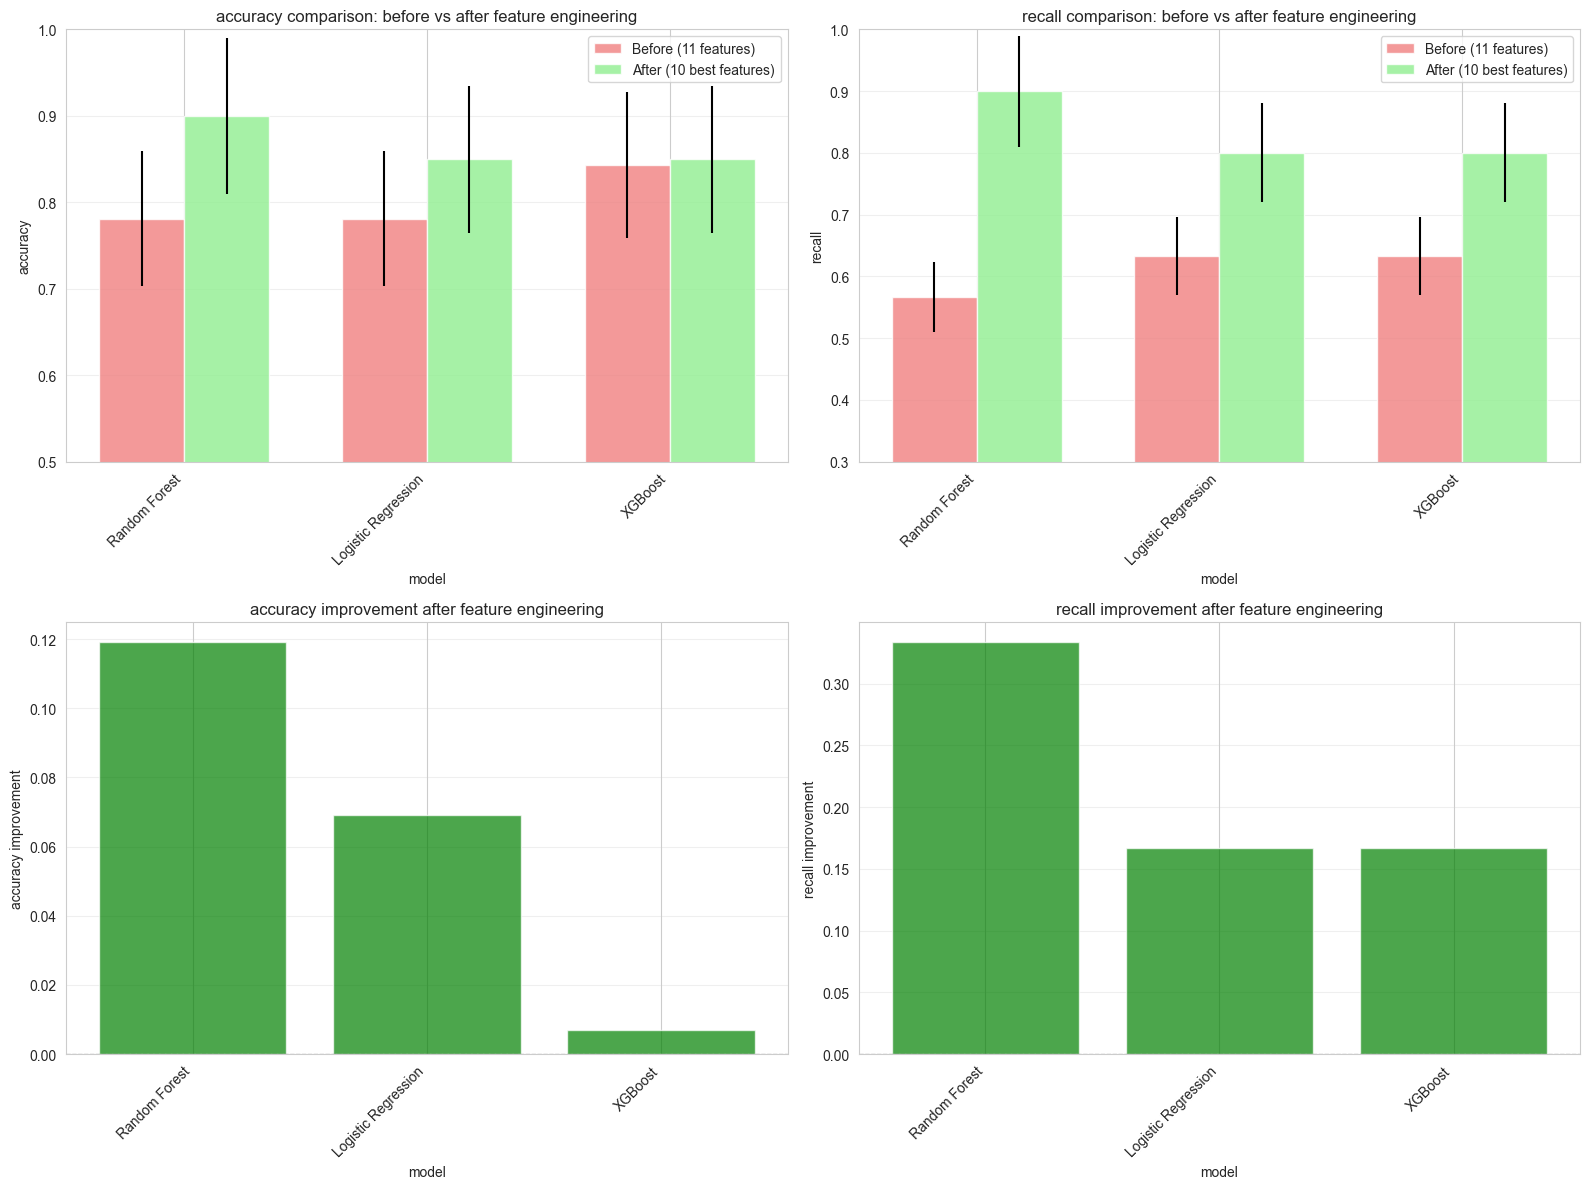


SUMMARY OF IMPROVEMENTS

average accuracy improvement: 0.0650
average recall improvement: 0.2222

models with improved accuracy: 3/3
models with improved recall: 3/3

best accuracy improvement: Random Forest (0.1190)
best recall improvement: Random Forest (0.3333)


In [99]:
# visualization of comparison
if len(comparison_df) == 0:
    print("no data available for visualization")
else:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    models = comparison_df['model'].tolist()
    x_pos = np.arange(len(models))
    width = 0.35

    # accuracy comparison
    axes[0, 0].bar(x_pos - width/2, comparison_df['before_accuracy'], width, 
               label='Before (11 features)', alpha=0.8, color='lightcoral', yerr=comparison_df['before_accuracy']*0.1)
    axes[0, 0].bar(x_pos + width/2, comparison_df['after_accuracy'], width,
                   label='After (10 best features)', alpha=0.8, color='lightgreen', yerr=comparison_df['after_accuracy']*0.1)
    axes[0, 0].set_xlabel('model')
    axes[0, 0].set_ylabel('accuracy')
    axes[0, 0].set_title('accuracy comparison: before vs after feature engineering')
    axes[0, 0].set_xticks(x_pos)
    axes[0, 0].set_xticklabels(models, rotation=45, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    axes[0, 0].set_ylim([0.5, 1.0])

    # recall comparison
    axes[0, 1].bar(x_pos - width/2, comparison_df['before_recall'], width,
                   label='Before (11 features)', alpha=0.8, color='lightcoral', yerr=comparison_df['before_recall']*0.1)
    axes[0, 1].bar(x_pos + width/2, comparison_df['after_recall'], width,
                   label='After (10 best features)', alpha=0.8, color='lightgreen', yerr=comparison_df['after_recall']*0.1)
    axes[0, 1].set_xlabel('model')
    axes[0, 1].set_ylabel('recall')
    axes[0, 1].set_title('recall comparison: before vs after feature engineering')
    axes[0, 1].set_xticks(x_pos)
    axes[0, 1].set_xticklabels(models, rotation=45, ha='right')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    axes[0, 1].set_ylim([0.3, 1.0])

    # improvement in accuracy
    axes[1, 0].bar(models, comparison_df['accuracy_improvement'], alpha=0.7,
                   color=['green' if x > 0 else 'red' for x in comparison_df['accuracy_improvement']])
    axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    axes[1, 0].set_xlabel('model')
    axes[1, 0].set_ylabel('accuracy improvement')
    axes[1, 0].set_title('accuracy improvement after feature engineering')
    axes[1, 0].set_xticklabels(models, rotation=45, ha='right')
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # improvement in recall
    axes[1, 1].bar(models, comparison_df['recall_improvement'], alpha=0.7,
                   color=['green' if x > 0 else 'red' for x in comparison_df['recall_improvement']])
    axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    axes[1, 1].set_xlabel('model')
    axes[1, 1].set_ylabel('recall improvement')
    axes[1, 1].set_title('recall improvement after feature engineering')
    axes[1, 1].set_xticklabels(models, rotation=45, ha='right')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # summary statistics
    print("\n" + "="*70)
    print("SUMMARY OF IMPROVEMENTS")
    print("="*70)
    print(f"\naverage accuracy improvement: {comparison_df['accuracy_improvement'].mean():.4f}")
    print(f"average recall improvement: {comparison_df['recall_improvement'].mean():.4f}")
    print(f"\nmodels with improved accuracy: {sum(comparison_df['accuracy_improvement'] > 0)}/{len(comparison_df)}")
    print(f"models with improved recall: {sum(comparison_df['recall_improvement'] > 0)}/{len(comparison_df)}")

    if len(comparison_df) > 0:
        best_acc_idx = comparison_df['accuracy_improvement'].idxmax()
        best_recall_idx = comparison_df['recall_improvement'].idxmax()

        print(f"\nbest accuracy improvement: {comparison_df.iloc[best_acc_idx]['model']} "
              f"({comparison_df['accuracy_improvement'].max():.4f})")
        print(f"best recall improvement: {comparison_df.iloc[best_recall_idx]['model']} "
              f"({comparison_df['recall_improvement'].max():.4f})")


RUNNING MODELS WITH ALL FEATURES (INCLUDING ENGINEERED)

using all 20 features:
features: ['frac_NK', 'frac_T_cells', 'frac_CD8_T', 'frac_CD4_T', 'frac_B_cells', 'frac_Dendritic', 'frac_Plasma', 'frac_Myeloid', 'CD8_memory_frac', 'CD8_exhaust_frac', 'CD8_mem_exh_ratio', 'total_immune_frac', 'cd8_cd4_ratio', 'cd8_total_t_ratio', 'lymphoid_frac', 'myeloid_frac', 'lymphoid_myeloid_ratio', 'cd8_state_dominance', 'effector_frac', 'effector_regulatory_ratio']

MODEL 1: RANDOM FOREST (ALL FEATURES)
quick accuracy check: 0.8500 ± 0.2000

detailed evaluation:

fold 1/5
  accuracy:           0.750
  balanced accuracy:  0.750
  precision:          0.667
  recall:             1.000
  f1-score:           0.800
  roc auc:            1.000
  pr auc (avgprec):   1.000

fold 2/5
  accuracy:           1.000
  balanced accuracy:  1.000
  precision:          1.000
  recall:             1.000
  f1-score:           1.000
  roc auc:            1.000
  pr auc (avgprec):   1.000

fold 3/5
  accuracy:          

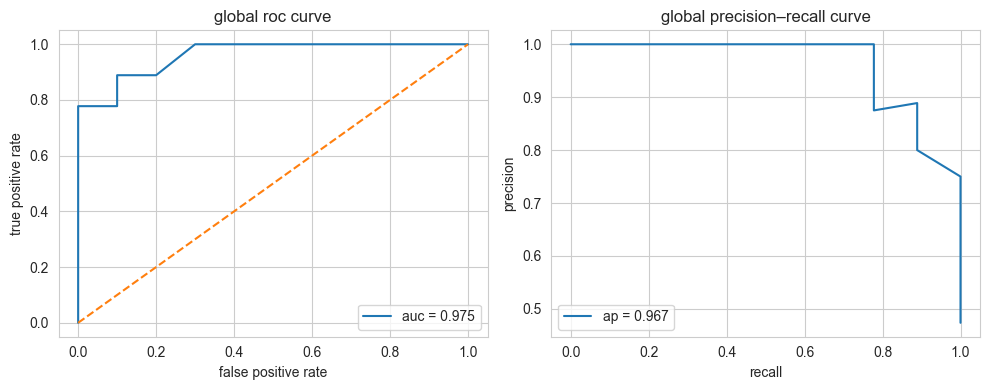


MODEL 2: LOGISTIC REGRESSION (ALL FEATURES)
quick accuracy check: 0.8500 ± 0.2000

detailed evaluation:

fold 1/5
  accuracy:           0.750
  balanced accuracy:  0.750
  precision:          0.667
  recall:             1.000
  f1-score:           0.800
  roc auc:            1.000
  pr auc (avgprec):   1.000

fold 2/5
  accuracy:           1.000
  balanced accuracy:  1.000
  precision:          1.000
  recall:             1.000
  f1-score:           1.000
  roc auc:            1.000
  pr auc (avgprec):   1.000

fold 3/5
  accuracy:           0.500
  balanced accuracy:  0.500
  precision:          0.000
  recall:             0.000
  f1-score:           0.000
  roc auc:            0.750
  pr auc (avgprec):   0.833

fold 4/5
  accuracy:           1.000
  balanced accuracy:  1.000
  precision:          1.000
  recall:             1.000
  f1-score:           1.000
  roc auc:            1.000
  pr auc (avgprec):   1.000

fold 5/5
  accuracy:           1.000
  balanced accuracy:  1.000
  pre

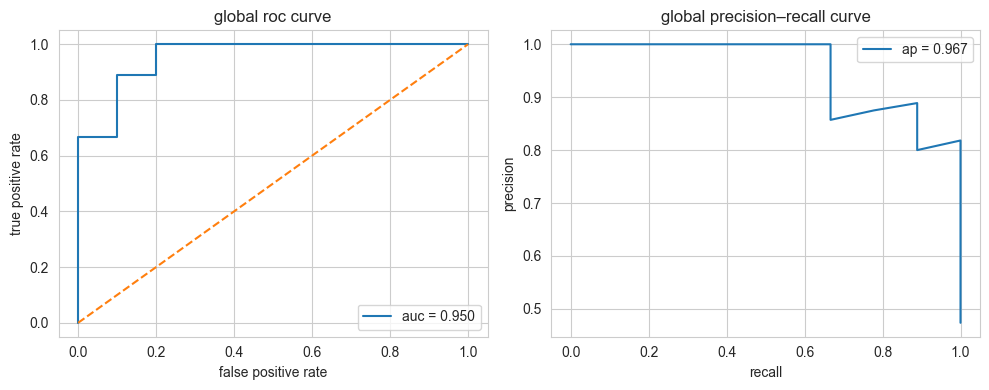


MODEL 3: XGBOOST (ALL FEATURES)
quick accuracy check: 0.8000 ± 0.1871

detailed evaluation:

fold 1/5
  accuracy:           0.750
  balanced accuracy:  0.750
  precision:          0.667
  recall:             1.000
  f1-score:           0.800
  roc auc:            1.000
  pr auc (avgprec):   1.000

fold 2/5
  accuracy:           0.750
  balanced accuracy:  0.750
  precision:          1.000
  recall:             0.500
  f1-score:           0.667
  roc auc:            1.000
  pr auc (avgprec):   1.000

fold 3/5
  accuracy:           0.500
  balanced accuracy:  0.500
  precision:          0.000
  recall:             0.000
  f1-score:           0.000
  roc auc:            1.000
  pr auc (avgprec):   1.000

fold 4/5
  accuracy:           1.000
  balanced accuracy:  1.000
  precision:          1.000
  recall:             1.000
  f1-score:           1.000
  roc auc:            1.000
  pr auc (avgprec):   1.000

fold 5/5
  accuracy:           1.000
  balanced accuracy:  1.000
  precision:     

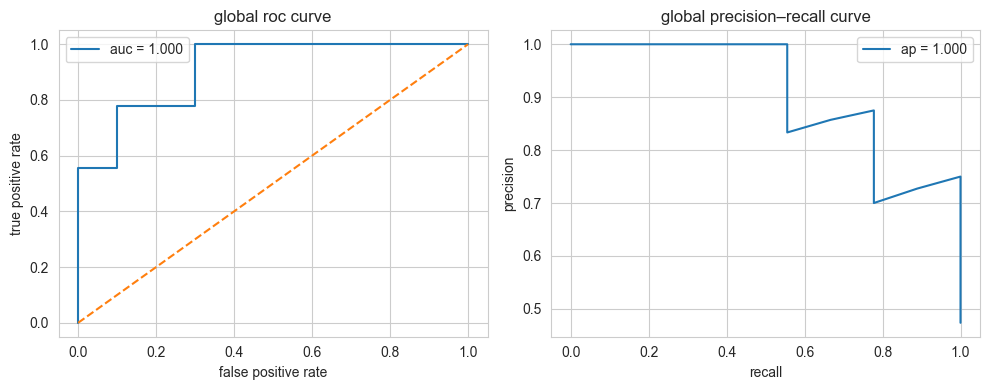

In [100]:
print("="*70)
print("RUNNING MODELS WITH ALL FEATURES (INCLUDING ENGINEERED)")
print("="*70)

# use all features (original + engineered)
X_all = X.copy()  # this already has all features from df_eng
y_all = y.copy()

print(f"\nusing all {len(X_all.columns)} features:")
print(f"features: {list(X_all.columns)}")

# setup cross validation
cv_all = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nMODEL 1: RANDOM FOREST (ALL FEATURES)")

rf_all = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42)

# quick accuracy check
rf_all_scores = cross_val_score(rf_all, X_all, y_all, cv=cv_all, scoring='accuracy')
print(f"quick accuracy check: {rf_all_scores.mean():.4f} ± {rf_all_scores.std():.4f}")

# detailed evaluation (same as original notebook)
print("\ndetailed evaluation:")
rf_all_results = evaluate_binary_model_cv(rf_all, X_all, y_all, n_splits=5, random_state=42, plot_curves=True, verbose=True)

# extract metrics
rf_all_metrics = extract_metrics_from_results(rf_all_results)

print("\nMODEL 2: LOGISTIC REGRESSION (ALL FEATURES)")

lr_all_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=500, penalty='l2', class_weight='balanced', random_state=42))
])

# quick accuracy check
lr_all_scores = cross_val_score(lr_all_pipe, X_all, y_all, cv=cv_all, scoring='accuracy')
print(f"quick accuracy check: {lr_all_scores.mean():.4f} ± {lr_all_scores.std():.4f}")

# detailed evaluation (same as original notebook)
print("\ndetailed evaluation:")
lr_all_results = evaluate_binary_model_cv(lr_all_pipe, X_all, y_all, n_splits=5, random_state=42, plot_curves=True, verbose=True)

# extract metrics
lr_all_metrics = extract_metrics_from_results(lr_all_results)

if xgboost_available:
    print("\nMODEL 3: XGBOOST (ALL FEATURES)")

    xgb_all = XGBClassifier(
        n_estimators=500,
        learning_rate=0.02,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss'
    )

    # quick accuracy check
    xgb_all_scores = cross_val_score(xgb_all, X_all, y_all, cv=cv_all, scoring='accuracy')
    print(f"quick accuracy check: {xgb_all_scores.mean():.4f} ± {xgb_all_scores.std():.4f}")

    # detailed evaluation (same as original notebook)
    print("\ndetailed evaluation:")
    xgb_all_results = evaluate_binary_model_cv(xgb_all, X_all, y_all, n_splits=5, random_state=42, plot_curves=True, verbose=True)

    # extract metrics
    xgb_all_metrics = extract_metrics_from_results(xgb_all_results)


In [101]:
print("="*70)
print("COMPARISON: BEFORE (11 FEATURES) vs AFTER (ALL FEATURES)")
print("="*70)

# original results (11 base features)
original_all = {
    'Random Forest': {
        'accuracy': 0.7810,
        'accuracy_std': 0.0759,
        'recall': 0.5667,
        'recall_std': 0.0816,
        'balanced_accuracy': 0.7333,
        'balanced_accuracy_std': 0.0677
    },
    'Logistic Regression': {
        'accuracy': 0.7810,
        'accuracy_std': 0.1486,
        'recall': 0.6333,
        'recall_std': 0.1944,
        'balanced_accuracy': 0.7417,
        'balanced_accuracy_std': 0.1453
    },
    'XGBoost': {
        'accuracy': 0.8429,
        'accuracy_std': 0.0911,
        'recall': 0.6333,
        'recall_std': 0.1944,
        'balanced_accuracy': 0.7917,
        'balanced_accuracy_std': 0.1054
    }
}

# new results with all features
all_features_results = {
    'Random Forest': {
        'accuracy': rf_all_scores.mean(),
        'accuracy_std': rf_all_scores.std(),
        'recall': rf_all_metrics['recall'],
        'recall_std': rf_all_metrics['recall_std'],
        'balanced_accuracy': rf_all_metrics['balanced_accuracy'],
        'balanced_accuracy_std': rf_all_metrics['balanced_accuracy_std']
    },
    'Logistic Regression': {
        'accuracy': lr_all_scores.mean(),
        'accuracy_std': lr_all_scores.std(),
        'recall': lr_all_metrics['recall'],
        'recall_std': lr_all_metrics['recall_std'],
        'balanced_accuracy': lr_all_metrics['balanced_accuracy'],
        'balanced_accuracy_std': lr_all_metrics['balanced_accuracy_std']
    }
}

if xgboost_available:
    all_features_results['XGBoost'] = {
        'accuracy': xgb_all_scores.mean(),
        'accuracy_std': xgb_all_scores.std(),
        'recall': xgb_all_metrics['recall'],
        'recall_std': xgb_all_metrics['recall_std'],
        'balanced_accuracy': xgb_all_metrics['balanced_accuracy'],
        'balanced_accuracy_std': xgb_all_metrics['balanced_accuracy_std']
    }

# create comparison dataframe
comparison_all_data = []
for model_name in ['Random Forest', 'Logistic Regression', 'XGBoost']:
    if model_name in original_all and model_name in all_features_results:
        comparison_all_data.append({
            'model': model_name,
            'before_accuracy': original_all[model_name]['accuracy'],
            'after_accuracy': all_features_results[model_name]['accuracy'],
            'accuracy_improvement': all_features_results[model_name]['accuracy'] - original_all[model_name]['accuracy'],
            'before_recall': original_all[model_name]['recall'],
            'after_recall': all_features_results[model_name]['recall'],
            'recall_improvement': all_features_results[model_name]['recall'] - original_all[model_name]['recall'],
            'before_balanced_acc': original_all[model_name]['balanced_accuracy'],
            'after_balanced_acc': all_features_results[model_name]['balanced_accuracy'],
            'balanced_acc_improvement': all_features_results[model_name]['balanced_accuracy'] - original_all[model_name]['balanced_accuracy']
        })

comparison_all_df = pd.DataFrame(comparison_all_data)
comparison_all_df = comparison_all_df.reset_index(drop=True)

print(f"\ncomparing {len(original_all)} models:")
print(f"before: 11 original features")
print(f"after: {len(X_all.columns)} features (11 original + {len(X_all.columns) - 11} engineered)")

print("\ncomparison table:")
print(comparison_all_df[['model', 'before_accuracy', 'after_accuracy', 'accuracy_improvement', 
                         'before_recall', 'after_recall', 'recall_improvement']].to_string(index=False))


COMPARISON: BEFORE (11 FEATURES) vs AFTER (ALL FEATURES)

comparing 3 models:
before: 11 original features
after: 20 features (11 original + 9 engineered)

comparison table:
              model  before_accuracy  after_accuracy  accuracy_improvement  before_recall  after_recall  recall_improvement
      Random Forest           0.7810            0.85                0.0690         0.5667           0.8              0.2333
Logistic Regression           0.7810            0.85                0.0690         0.6333           0.8              0.1667
            XGBoost           0.8429            0.80               -0.0429         0.6333           0.7              0.0667


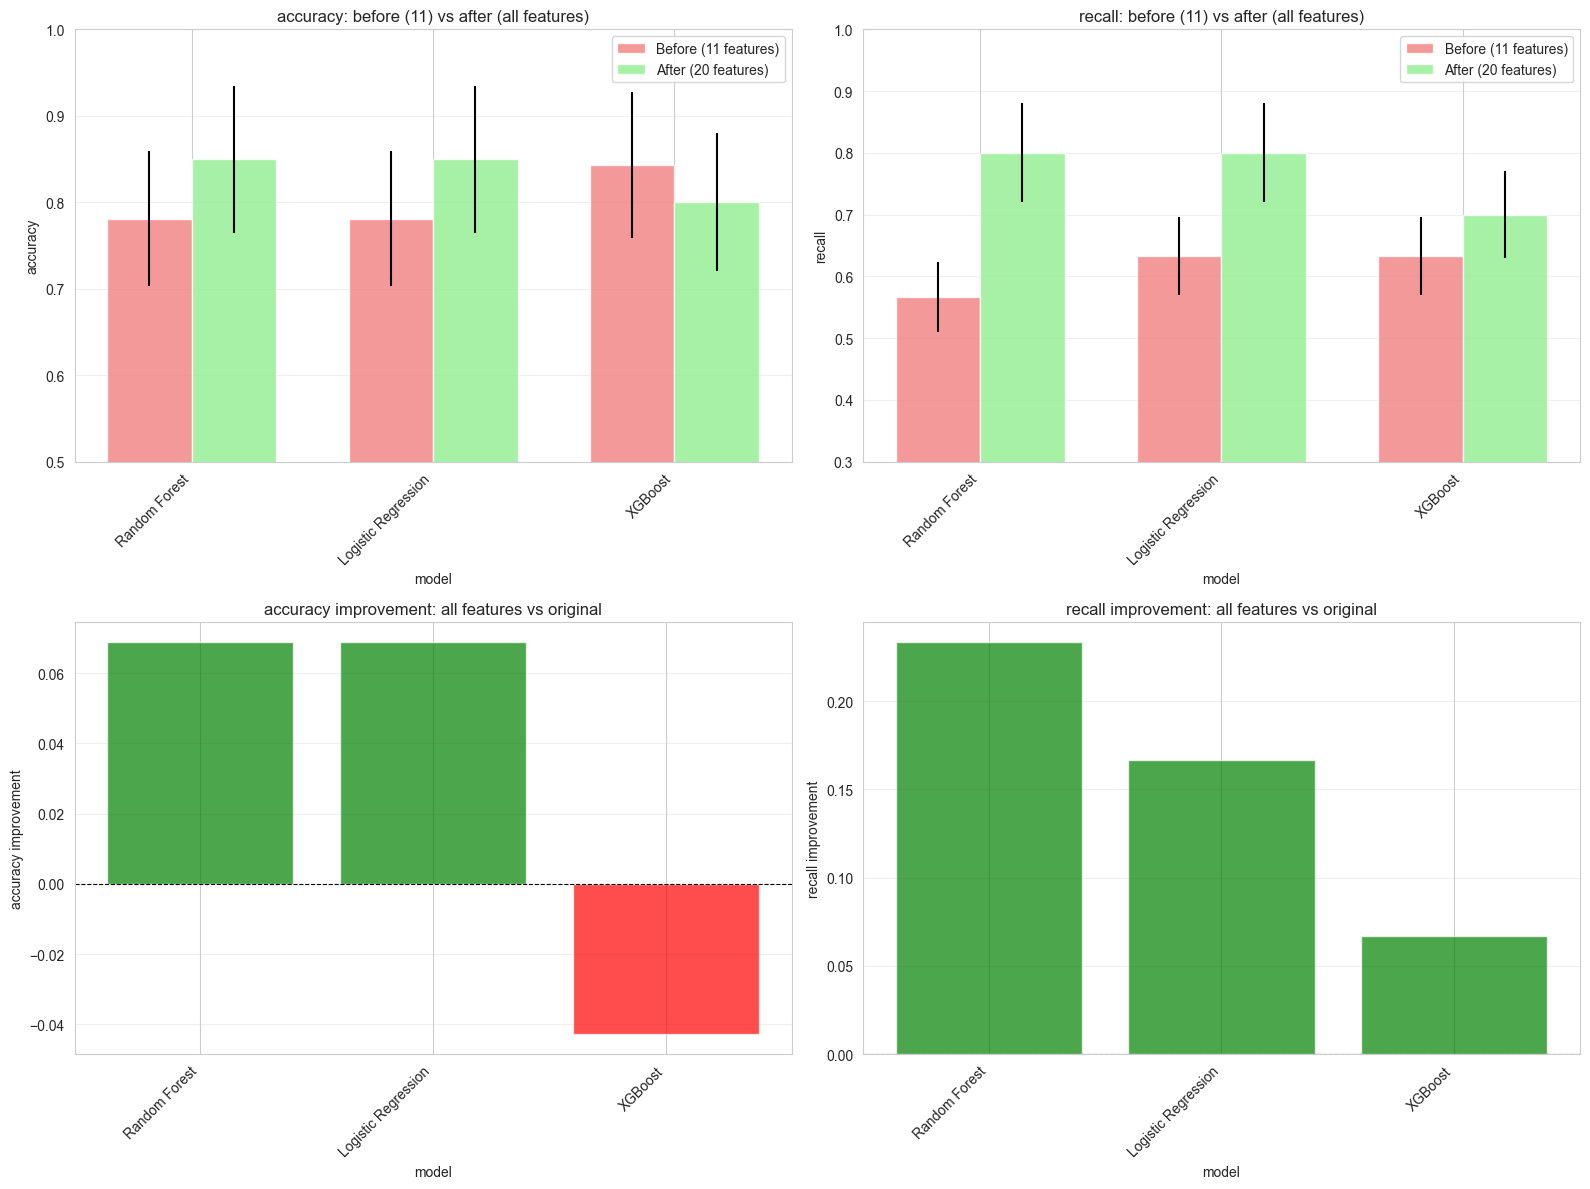


SUMMARY: ALL FEATURES vs ORIGINAL

average accuracy improvement: 0.0317
average recall improvement: 0.1556

models with improved accuracy: 2/3
models with improved recall: 3/3

best accuracy improvement: Random Forest (0.0690)
best recall improvement: Random Forest (0.2333)

feature count: 20 features (11 original + 9 engineered)


In [102]:
# visualization of comparison with all features
if len(comparison_all_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    models_all = comparison_all_df['model'].tolist()
    x_pos_all = np.arange(len(models_all))
    width_all = 0.35

    # accuracy comparison
    axes[0, 0].bar(x_pos_all - width_all/2, comparison_all_df['before_accuracy'], width_all,
                   label='Before (11 features)', alpha=0.8, color='lightcoral', 
                   yerr=comparison_all_df['before_accuracy']*0.1)
    axes[0, 0].bar(x_pos_all + width_all/2, comparison_all_df['after_accuracy'], width_all,
                   label=f'After ({len(X_all.columns)} features)', alpha=0.8, color='lightgreen',
                   yerr=comparison_all_df['after_accuracy']*0.1)
    axes[0, 0].set_xlabel('model')
    axes[0, 0].set_ylabel('accuracy')
    axes[0, 0].set_title('accuracy: before (11) vs after (all features)')
    axes[0, 0].set_xticks(x_pos_all)
    axes[0, 0].set_xticklabels(models_all, rotation=45, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    axes[0, 0].set_ylim([0.5, 1.0])

    # recall comparison
    axes[0, 1].bar(x_pos_all - width_all/2, comparison_all_df['before_recall'], width_all,
                   label='Before (11 features)', alpha=0.8, color='lightcoral',
                   yerr=comparison_all_df['before_recall']*0.1)
    axes[0, 1].bar(x_pos_all + width_all/2, comparison_all_df['after_recall'], width_all,
                   label=f'After ({len(X_all.columns)} features)', alpha=0.8, color='lightgreen',
                   yerr=comparison_all_df['after_recall']*0.1)
    axes[0, 1].set_xlabel('model')
    axes[0, 1].set_ylabel('recall')
    axes[0, 1].set_title('recall: before (11) vs after (all features)')
    axes[0, 1].set_xticks(x_pos_all)
    axes[0, 1].set_xticklabels(models_all, rotation=45, ha='right')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    axes[0, 1].set_ylim([0.3, 1.0])

    # improvement in accuracy
    axes[1, 0].bar(models_all, comparison_all_df['accuracy_improvement'], alpha=0.7,
                   color=['green' if x > 0 else 'red' for x in comparison_all_df['accuracy_improvement']])
    axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    axes[1, 0].set_xlabel('model')
    axes[1, 0].set_ylabel('accuracy improvement')
    axes[1, 0].set_title('accuracy improvement: all features vs original')
    axes[1, 0].set_xticklabels(models_all, rotation=45, ha='right')
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # improvement in recall
    axes[1, 1].bar(models_all, comparison_all_df['recall_improvement'], alpha=0.7,
                   color=['green' if x > 0 else 'red' for x in comparison_all_df['recall_improvement']])
    axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    axes[1, 1].set_xlabel('model')
    axes[1, 1].set_ylabel('recall improvement')
    axes[1, 1].set_title('recall improvement: all features vs original')
    axes[1, 1].set_xticklabels(models_all, rotation=45, ha='right')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # summary statistics
    print("\n" + "="*70)
    print("SUMMARY: ALL FEATURES vs ORIGINAL")
    print("="*70)
    print(f"\naverage accuracy improvement: {comparison_all_df['accuracy_improvement'].mean():.4f}")
    print(f"average recall improvement: {comparison_all_df['recall_improvement'].mean():.4f}")
    print(f"\nmodels with improved accuracy: {sum(comparison_all_df['accuracy_improvement'] > 0)}/{len(comparison_all_df)}")
    print(f"models with improved recall: {sum(comparison_all_df['recall_improvement'] > 0)}/{len(comparison_all_df)}")

    if len(comparison_all_df) > 0:
        best_acc_idx_all = comparison_all_df['accuracy_improvement'].idxmax()
        best_recall_idx_all = comparison_all_df['recall_improvement'].idxmax()

        print(f"\nbest accuracy improvement: {comparison_all_df.iloc[best_acc_idx_all]['model']} "
              f"({comparison_all_df['accuracy_improvement'].max():.4f})")
        print(f"best recall improvement: {comparison_all_df.iloc[best_recall_idx_all]['model']} "
              f"({comparison_all_df['recall_improvement'].max():.4f})")
        
        print(f"\nfeature count: {len(X_all.columns)} features (11 original + {len(X_all.columns) - 11} engineered)")
else:
    print("no data available for visualization")


In [103]:
print("="*70)
print("ADVANCED FEATURE ENGINEERING FOR RECALL IMPROVEMENT")
print("="*70)

df_advanced = df_eng.copy()

print("\ncreating advanced engineered features...")

# interaction features between important cell types
df_advanced['cd8_nk_interaction'] = df_advanced['frac_CD8_T'] * df_advanced['frac_NK']
df_advanced['cd8_b_interaction'] = df_advanced['frac_CD8_T'] * df_advanced['frac_B_cells']
df_advanced['cd8_myeloid_interaction'] = df_advanced['frac_CD8_T'] * df_advanced['frac_Myeloid']
df_advanced['memory_exhaust_interaction'] = df_advanced['CD8_memory_frac'] * df_advanced['CD8_exhaust_frac']

# squared features for non-linear relationships
df_advanced['cd8_state_dominance_sq'] = df_advanced['cd8_state_dominance'] ** 2
df_advanced['cd8_mem_exh_ratio_sq'] = df_advanced['CD8_mem_exh_ratio'] ** 2
df_advanced['cd8_cd4_ratio_sq'] = df_advanced['cd8_cd4_ratio'] ** 2

# log transformations (add small epsilon to avoid log(0))
epsilon = 1e-6
df_advanced['log_cd8_mem_exh_ratio'] = np.log1p(df_advanced['CD8_mem_exh_ratio'] + epsilon)
df_advanced['log_cd8_state_dominance'] = np.log1p(df_advanced['cd8_state_dominance'] + epsilon)
df_advanced['log_lymphoid_myeloid_ratio'] = np.log1p(df_advanced['lymphoid_myeloid_ratio'] + epsilon)

# ratio combinations
df_advanced['cd8_memory_to_total_t'] = df_advanced['CD8_memory_frac'] / (df_advanced['frac_T_cells'] + epsilon)
df_advanced['cd8_exhaust_to_total_t'] = df_advanced['CD8_exhaust_frac'] / (df_advanced['frac_T_cells'] + epsilon)
df_advanced['effector_to_total_immune'] = df_advanced['effector_frac'] / (df_advanced['total_immune_frac'] + epsilon)

# immune cell diversity (simplified entropy-like measure)
celltype_fracs = df_advanced[[c for c in df_advanced.columns if c.startswith('frac_')]].values
df_advanced['immune_diversity'] = -np.sum(celltype_fracs * np.log1p(celltype_fracs + epsilon), axis=1)

# cd8 state balance features
df_advanced['cd8_state_balance'] = 1 - abs(df_advanced['cd8_state_dominance'])
df_advanced['cd8_memory_dominance'] = df_advanced['CD8_memory_frac'] / (df_advanced['CD8_memory_frac'] + df_advanced['CD8_exhaust_frac'] + epsilon)

# t cell subset ratios
df_advanced['cd8_to_all_t'] = df_advanced['frac_CD8_T'] / (df_advanced['frac_T_cells'] + epsilon)
df_advanced['cd4_to_all_t'] = df_advanced['frac_CD4_T'] / (df_advanced['frac_T_cells'] + epsilon)

# adaptive vs innate balance
adaptive_cols = ['frac_CD8_T', 'frac_CD4_T', 'frac_T_cells', 'frac_B_cells', 'frac_Plasma']
innate_cols = ['frac_NK', 'frac_Myeloid', 'frac_Dendritic']
df_advanced['adaptive_frac'] = df_advanced[[c for c in adaptive_cols if c in df_advanced.columns]].sum(axis=1)
df_advanced['innate_frac'] = df_advanced[[c for c in innate_cols if c in df_advanced.columns]].sum(axis=1)
df_advanced['adaptive_innate_ratio'] = df_advanced['adaptive_frac'] / (df_advanced['innate_frac'] + epsilon)

# cd8 functional state score (weighted combination)
df_advanced['cd8_functional_score'] = (df_advanced['CD8_memory_frac'] * 1.5) - (df_advanced['CD8_exhaust_frac'] * 0.5)

print(f"created {len(df_advanced.columns) - len(df_eng.columns)} additional features")
print(f"total features now: {len(df_advanced.columns) - 2}")  # excluding PatientID and Response

new_advanced_features = [c for c in df_advanced.columns if c not in df_eng.columns]
print(f"\nnew advanced features ({len(new_advanced_features)}):")
for i, feat in enumerate(new_advanced_features, 1):
    print(f"  {i:2d}. {feat}")

df_advanced.head()


ADVANCED FEATURE ENGINEERING FOR RECALL IMPROVEMENT

creating advanced engineered features...
created 22 additional features
total features now: 42

new advanced features (22):
   1. cd8_nk_interaction
   2. cd8_b_interaction
   3. cd8_myeloid_interaction
   4. memory_exhaust_interaction
   5. cd8_state_dominance_sq
   6. cd8_mem_exh_ratio_sq
   7. cd8_cd4_ratio_sq
   8. log_cd8_mem_exh_ratio
   9. log_cd8_state_dominance
  10. log_lymphoid_myeloid_ratio
  11. cd8_memory_to_total_t
  12. cd8_exhaust_to_total_t
  13. effector_to_total_immune
  14. immune_diversity
  15. cd8_state_balance
  16. cd8_memory_dominance
  17. cd8_to_all_t
  18. cd4_to_all_t
  19. adaptive_frac
  20. innate_frac
  21. adaptive_innate_ratio
  22. cd8_functional_score


,PatientID,frac_NK,frac_T_cells,frac_CD8_T,frac_CD4_T,frac_B_cells,frac_Dendritic,frac_Plasma,frac_Myeloid,CD8_memory_frac,...,effector_to_total_immune,immune_diversity,cd8_state_balance,cd8_memory_dominance,cd8_to_all_t,cd4_to_all_t,adaptive_frac,innate_frac,adaptive_innate_ratio,cd8_functional_score
0,P1,0.310044,0.253275,0.231441,0.087336,0.065502,0.039301,0.008734,0.004367,0.637555,...,0.541484,-0.202172,0.724891,0.637554,0.913789,0.344826,0.646288,0.353712,1.827155,0.775109
1,P2,0.189911,0.160237,0.421365,0.094955,0.011869,0.002967,0.014837,0.103858,0.121662,...,0.611275,-0.224240,0.243323,0.121662,2.629613,0.592589,0.703264,0.296736,2.369992,-0.256677
2,P3,0.261224,0.342857,0.142857,0.085714,0.061224,0.028571,0.012245,0.065306,0.461224,...,0.404081,-0.196549,0.922449,0.461224,0.416665,0.249999,0.644898,0.355102,1.816087,0.422449
3,P4,0.183280,0.135048,0.176849,0.109325,0.048232,0.032154,0.025723,0.289389,0.356913,...,0.360128,-0.165589,0.713826,0.356913,1.309514,0.809518,0.495177,0.504823,0.980890,0.213826
4,P6,0.038194,0.086806,0.083333,0.187500,0.045139,0.045139,0.385417,0.128472,0.267361,...,0.121528,-0.192710,0.534722,0.267361,0.959989,2.159975,0.788194,0.211806,3.721294,0.034722


In [104]:
print("testing models with advanced features...")

# prepare data with all advanced features
feature_cols_advanced = [c for c in df_advanced.columns if c not in ['PatientID', 'Response']]
X_advanced = df_advanced[feature_cols_advanced].copy()
y_advanced = y.copy()

print(f"\nfeature matrix shape: {X_advanced.shape}")
print(f"total features: {len(feature_cols_advanced)}")

# setup cross validation
cv_advanced = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\n" + "="*60)
print("MODEL 1: RANDOM FOREST (ADVANCED FEATURES)")
print("="*60)

rf_adv = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42)
rf_adv_scores = cross_val_score(rf_adv, X_advanced, y_advanced, cv=cv_advanced, scoring='accuracy')
rf_adv_scores_balanced = cross_val_score(rf_adv, X_advanced, y_advanced, cv=cv_advanced, scoring='balanced_accuracy')

print(f"accuracy: {rf_adv_scores.mean():.4f} ± {rf_adv_scores.std():.4f}")
print(f"balanced accuracy: {rf_adv_scores_balanced.mean():.4f} ± {rf_adv_scores_balanced.std():.4f}")

rf_adv_metrics = compute_detailed_metrics(rf_adv, X_advanced, y_advanced, cv_advanced)
print(f"recall: {rf_adv_metrics['recall']:.4f} ± {rf_adv_metrics['recall_std']:.4f}")

print("\n" + "="*60)
print("MODEL 2: LOGISTIC REGRESSION (ADVANCED FEATURES)")
print("="*60)

lr_adv_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=500, penalty='l2', class_weight='balanced', random_state=42))
])

lr_adv_scores = cross_val_score(lr_adv_pipe, X_advanced, y_advanced, cv=cv_advanced, scoring='accuracy')
lr_adv_scores_balanced = cross_val_score(lr_adv_pipe, X_advanced, y_advanced, cv=cv_advanced, scoring='balanced_accuracy')

print(f"accuracy: {lr_adv_scores.mean():.4f} ± {lr_adv_scores.std():.4f}")
print(f"balanced accuracy: {lr_adv_scores_balanced.mean():.4f} ± {lr_adv_scores_balanced.std():.4f}")

lr_adv_metrics = compute_detailed_metrics(lr_adv_pipe, X_advanced, y_advanced, cv_advanced)
print(f"recall: {lr_adv_metrics['recall']:.4f} ± {lr_adv_metrics['recall_std']:.4f}")

if xgboost_available:
    print("\n" + "="*60)
    print("MODEL 3: XGBOOST (ADVANCED FEATURES)")
    print("="*60)

    xgb_adv = XGBClassifier(
        n_estimators=500,
        learning_rate=0.02,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss'
    )

    xgb_adv_scores = cross_val_score(xgb_adv, X_advanced, y_advanced, cv=cv_advanced, scoring='accuracy')
    xgb_adv_scores_balanced = cross_val_score(xgb_adv, X_advanced, y_advanced, cv=cv_advanced, scoring='balanced_accuracy')

    print(f"accuracy: {xgb_adv_scores.mean():.4f} ± {xgb_adv_scores.std():.4f}")
    print(f"balanced accuracy: {xgb_adv_scores_balanced.mean():.4f} ± {xgb_adv_scores_balanced.std():.4f}")

    xgb_adv_metrics = compute_detailed_metrics(xgb_adv, X_advanced, y_advanced, cv_advanced)
    print(f"recall: {xgb_adv_metrics['recall']:.4f} ± {xgb_adv_metrics['recall_std']:.4f}")


testing models with advanced features...

feature matrix shape: (19, 42)
total features: 42

MODEL 1: RANDOM FOREST (ADVANCED FEATURES)
accuracy: 0.8500 ± 0.2000
balanced accuracy: 0.8500 ± 0.2000
recall: 0.8000 ± 0.4000

MODEL 2: LOGISTIC REGRESSION (ADVANCED FEATURES)
accuracy: 0.8500 ± 0.2000
balanced accuracy: 0.8500 ± 0.2000
recall: 0.8000 ± 0.4000

MODEL 3: XGBOOST (ADVANCED FEATURES)
accuracy: 0.8000 ± 0.1871
balanced accuracy: 0.8000 ± 0.1871
recall: 0.7000 ± 0.4000


In [105]:
print("="*70)
print("COMPARISON: ORIGINAL vs ALL FEATURES vs ADVANCED FEATURES")
print("="*70)

# collect all results
comparison_recall_data = []

# original results
original_recall = {
    'Random Forest': {'recall': 0.5667, 'accuracy': 0.7810},
    'Logistic Regression': {'recall': 0.6333, 'accuracy': 0.7810},
    'XGBoost': {'recall': 0.6333, 'accuracy': 0.8429}
}

# all features results (from cell 21)
all_features_recall = {
    'Random Forest': {'recall': rf_all_metrics['recall'], 'accuracy': rf_all_scores.mean()},
    'Logistic Regression': {'recall': lr_all_metrics['recall'], 'accuracy': lr_all_scores.mean()}
}
if xgboost_available:
    all_features_recall['XGBoost'] = {'recall': xgb_all_metrics['recall'], 'accuracy': xgb_all_scores.mean()}

# advanced features results
advanced_recall = {
    'Random Forest': {'recall': rf_adv_metrics['recall'], 'accuracy': rf_adv_scores.mean()},
    'Logistic Regression': {'recall': lr_adv_metrics['recall'], 'accuracy': lr_adv_scores.mean()}
}
if xgboost_available:
    advanced_recall['XGBoost'] = {'recall': xgb_adv_metrics['recall'], 'accuracy': xgb_adv_scores.mean()}

# create comparison
for model_name in ['Random Forest', 'Logistic Regression', 'XGBoost']:
    if model_name in original_recall and model_name in all_features_recall and model_name in advanced_recall:
        comparison_recall_data.append({
            'model': model_name,
            'original_recall': original_recall[model_name]['recall'],
            'all_features_recall': all_features_recall[model_name]['recall'],
            'advanced_recall': advanced_recall[model_name]['recall'],
            'recall_improvement_all': all_features_recall[model_name]['recall'] - original_recall[model_name]['recall'],
            'recall_improvement_advanced': advanced_recall[model_name]['recall'] - original_recall[model_name]['recall'],
            'original_accuracy': original_recall[model_name]['accuracy'],
            'all_features_accuracy': all_features_recall[model_name]['accuracy'],
            'advanced_accuracy': advanced_recall[model_name]['accuracy']
        })

comparison_recall_df = pd.DataFrame(comparison_recall_data)
comparison_recall_df = comparison_recall_df.reset_index(drop=True)

print(f"\nrecall comparison across feature sets:")
print(comparison_recall_df[['model', 'original_recall', 'all_features_recall', 'advanced_recall', 
                             'recall_improvement_all', 'recall_improvement_advanced']].to_string(index=False))

print(f"\naccuracy comparison across feature sets:")
print(comparison_recall_df[['model', 'original_accuracy', 'all_features_accuracy', 'advanced_accuracy']].to_string(index=False))


COMPARISON: ORIGINAL vs ALL FEATURES vs ADVANCED FEATURES

recall comparison across feature sets:
              model  original_recall  all_features_recall  advanced_recall  recall_improvement_all  recall_improvement_advanced
      Random Forest           0.5667                  0.8              0.8                  0.2333                       0.2333
Logistic Regression           0.6333                  0.8              0.8                  0.1667                       0.1667
            XGBoost           0.6333                  0.7              0.7                  0.0667                       0.0667

accuracy comparison across feature sets:
              model  original_accuracy  all_features_accuracy  advanced_accuracy
      Random Forest             0.7810                   0.85               0.85
Logistic Regression             0.7810                   0.85               0.85
            XGBoost             0.8429                   0.80               0.80


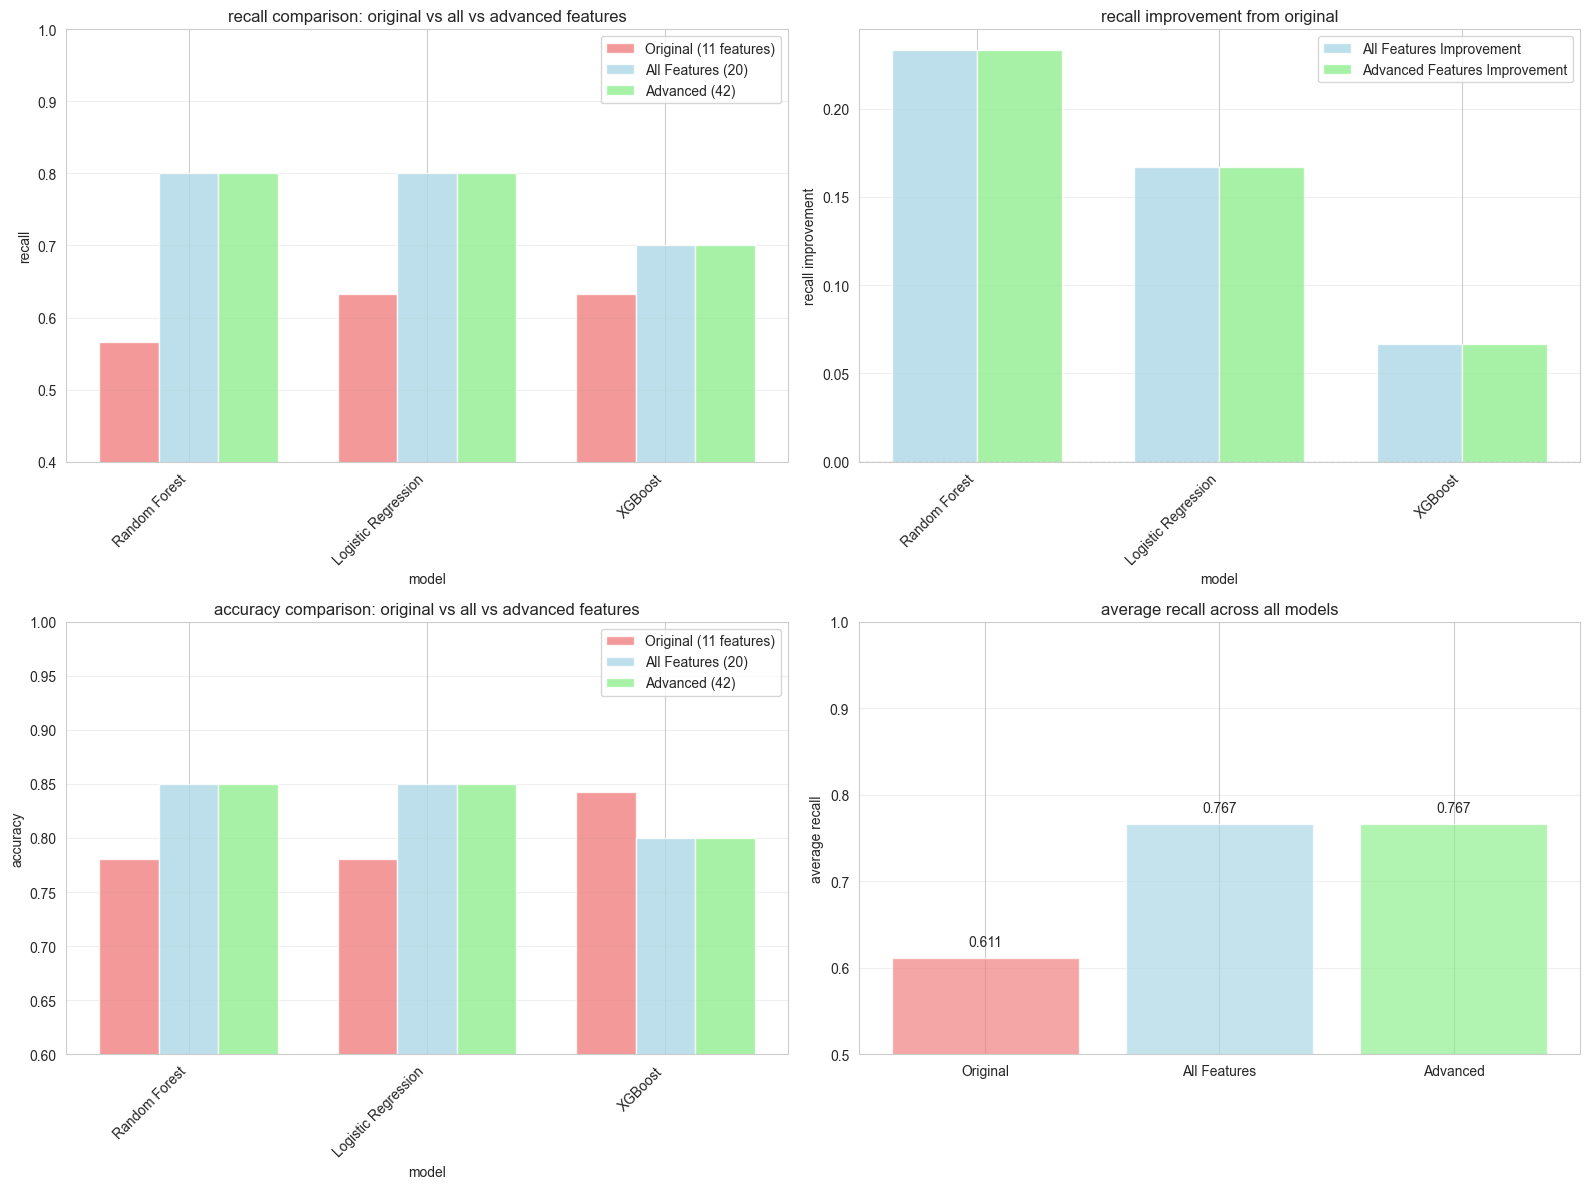


SUMMARY: RECALL IMPROVEMENT ANALYSIS

average recall - original: 0.6111
average recall - all features: 0.7667
average recall - advanced: 0.7667

overall recall improvement (all features): 0.1556
overall recall improvement (advanced): 0.1556

best recall improvement model: Random Forest
best recall value: 0.8000

feature counts:
  original: 11 features
  all features: 20 features
  advanced: 42 features
  additional advanced features: 22


In [106]:
# visualization of recall improvements
if len(comparison_recall_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    models_recall = comparison_recall_df['model'].tolist()
    x_pos_recall = np.arange(len(models_recall))
    width_recall = 0.25

    # recall comparison across all three feature sets
    axes[0, 0].bar(x_pos_recall - width_recall, comparison_recall_df['original_recall'], width_recall,
                   label='Original (11 features)', alpha=0.8, color='lightcoral')
    axes[0, 0].bar(x_pos_recall, comparison_recall_df['all_features_recall'], width_recall,
                   label=f'All Features ({len(X_all.columns)})', alpha=0.8, color='lightblue')
    axes[0, 0].bar(x_pos_recall + width_recall, comparison_recall_df['advanced_recall'], width_recall,
                   label=f'Advanced ({len(X_advanced.columns)})', alpha=0.8, color='lightgreen')
    axes[0, 0].set_xlabel('model')
    axes[0, 0].set_ylabel('recall')
    axes[0, 0].set_title('recall comparison: original vs all vs advanced features')
    axes[0, 0].set_xticks(x_pos_recall)
    axes[0, 0].set_xticklabels(models_recall, rotation=45, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    axes[0, 0].set_ylim([0.4, 1.0])

    # recall improvement from original
    x = np.arange(len(models_recall))
    width = 0.35
    axes[0, 1].bar(x - width/2, comparison_recall_df['recall_improvement_all'], width,
                   label='All Features Improvement', alpha=0.8, color='lightblue')
    axes[0, 1].bar(x + width/2, comparison_recall_df['recall_improvement_advanced'], width,
                   label='Advanced Features Improvement', alpha=0.8, color='lightgreen')
    axes[0, 1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    axes[0, 1].set_xlabel('model')
    axes[0, 1].set_ylabel('recall improvement')
    axes[0, 1].set_title('recall improvement from original')
    axes[0, 1].set_xticks(x)
    axes[0, 1].set_xticklabels(models_recall, rotation=45, ha='right')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3, axis='y')

    # accuracy comparison
    axes[1, 0].bar(x_pos_recall - width_recall, comparison_recall_df['original_accuracy'], width_recall,
                   label='Original (11 features)', alpha=0.8, color='lightcoral')
    axes[1, 0].bar(x_pos_recall, comparison_recall_df['all_features_accuracy'], width_recall,
                   label=f'All Features ({len(X_all.columns)})', alpha=0.8, color='lightblue')
    axes[1, 0].bar(x_pos_recall + width_recall, comparison_recall_df['advanced_accuracy'], width_recall,
                   label=f'Advanced ({len(X_advanced.columns)})', alpha=0.8, color='lightgreen')
    axes[1, 0].set_xlabel('model')
    axes[1, 0].set_ylabel('accuracy')
    axes[1, 0].set_title('accuracy comparison: original vs all vs advanced features')
    axes[1, 0].set_xticks(x_pos_recall)
    axes[1, 0].set_xticklabels(models_recall, rotation=45, ha='right')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    axes[1, 0].set_ylim([0.6, 1.0])

    # summary bar chart
    avg_recall_original = comparison_recall_df['original_recall'].mean()
    avg_recall_all = comparison_recall_df['all_features_recall'].mean()
    avg_recall_advanced = comparison_recall_df['advanced_recall'].mean()
    
    axes[1, 1].bar(['Original', 'All Features', 'Advanced'], 
                   [avg_recall_original, avg_recall_all, avg_recall_advanced],
                   alpha=0.7, color=['lightcoral', 'lightblue', 'lightgreen'])
    axes[1, 1].set_ylabel('average recall')
    axes[1, 1].set_title('average recall across all models')
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    axes[1, 1].set_ylim([0.5, 1.0])
    
    # add value labels on bars
    for i, v in enumerate([avg_recall_original, avg_recall_all, avg_recall_advanced]):
        axes[1, 1].text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    # summary statistics
    print("\n" + "="*70)
    print("SUMMARY: RECALL IMPROVEMENT ANALYSIS")
    print("="*70)
    print(f"\naverage recall - original: {avg_recall_original:.4f}")
    print(f"average recall - all features: {avg_recall_all:.4f}")
    print(f"average recall - advanced: {avg_recall_advanced:.4f}")
    print(f"\noverall recall improvement (all features): {avg_recall_all - avg_recall_original:.4f}")
    print(f"overall recall improvement (advanced): {avg_recall_advanced - avg_recall_original:.4f}")
    print(f"\nbest recall improvement model: {comparison_recall_df.loc[comparison_recall_df['recall_improvement_advanced'].idxmax(), 'model']}")
    print(f"best recall value: {comparison_recall_df['advanced_recall'].max():.4f}")
    
    print(f"\nfeature counts:")
    print(f"  original: 11 features")
    print(f"  all features: {len(X_all.columns)} features")
    print(f"  advanced: {len(X_advanced.columns)} features")
    print(f"  additional advanced features: {len(X_advanced.columns) - len(X_all.columns)}")
else:
    print("no data available for visualization")


In [107]:
print("="*70)
print("BEST PERFORMANCE ANALYSIS: ACCURACY & RECALL BY FEATURE SET")
print("="*70)

# collect all results from different feature sets
all_results = []

# original features (11)
original_feat = {
    'Random Forest': {'accuracy': 0.7810, 'recall': 0.5667, 'feature_set': 'Original (11)', 'num_features': 11},
    'Logistic Regression': {'accuracy': 0.7810, 'recall': 0.6333, 'feature_set': 'Original (11)', 'num_features': 11},
    'XGBoost': {'accuracy': 0.8429, 'recall': 0.6333, 'feature_set': 'Original (11)', 'num_features': 11}
}

# all features (20)
all_feat = {
    'Random Forest': {'accuracy': rf_all_scores.mean(), 'recall': rf_all_metrics['recall'], 
                      'feature_set': f'All Features ({len(X_all.columns)})', 'num_features': len(X_all.columns)},
    'Logistic Regression': {'accuracy': lr_all_scores.mean(), 'recall': lr_all_metrics['recall'],
                            'feature_set': f'All Features ({len(X_all.columns)})', 'num_features': len(X_all.columns)}
}
if xgboost_available:
    all_feat['XGBoost'] = {'accuracy': xgb_all_scores.mean(), 'recall': xgb_all_metrics['recall'],
                           'feature_set': f'All Features ({len(X_all.columns)})', 'num_features': len(X_all.columns)}

# best features (10)
best_feat = {
    'Random Forest': {'accuracy': rf_scores.mean(), 'recall': new_rf_metrics['recall'],
                     'feature_set': 'Best Selected (10)', 'num_features': 10},
    'Logistic Regression': {'accuracy': lr_scores.mean(), 'recall': new_lr_metrics['recall'],
                           'feature_set': 'Best Selected (10)', 'num_features': 10}
}
if xgboost_available:
    best_feat['XGBoost'] = {'accuracy': xgb_scores.mean(), 'recall': new_xgb_metrics['recall'],
                            'feature_set': 'Best Selected (10)', 'num_features': 10}

# advanced features
advanced_feat = {
    'Random Forest': {'accuracy': rf_adv_scores.mean(), 'recall': rf_adv_metrics['recall'],
                      'feature_set': f'Advanced ({len(X_advanced.columns)})', 'num_features': len(X_advanced.columns)},
    'Logistic Regression': {'accuracy': lr_adv_scores.mean(), 'recall': lr_adv_metrics['recall'],
                            'feature_set': f'Advanced ({len(X_advanced.columns)})', 'num_features': len(X_advanced.columns)}
}
if xgboost_available:
    advanced_feat['XGBoost'] = {'accuracy': xgb_adv_scores.mean(), 'recall': xgb_adv_metrics['recall'],
                                'feature_set': f'Advanced ({len(X_advanced.columns)})', 'num_features': len(X_advanced.columns)}

# find best for each model
models_list = ['Random Forest', 'Logistic Regression', 'XGBoost']
best_results = []

for model in models_list:
    if model not in original_feat:
        continue
    
    # collect all feature set results for this model
    model_results = []
    
    if model in original_feat:
        model_results.append(original_feat[model])
    if model in all_feat:
        model_results.append(all_feat[model])
    if model in best_feat:
        model_results.append(best_feat[model])
    if model in advanced_feat:
        model_results.append(advanced_feat[model])
    
    # find best accuracy
    best_acc = max(model_results, key=lambda x: x['accuracy'])
    
    # find best recall
    best_rec = max(model_results, key=lambda x: x['recall'])
    
    best_results.append({
        'model': model,
        'best_accuracy': best_acc['accuracy'],
        'best_accuracy_feature_set': best_acc['feature_set'],
        'best_accuracy_num_features': best_acc['num_features'],
        'best_recall': best_rec['recall'],
        'best_recall_feature_set': best_rec['feature_set'],
        'best_recall_num_features': best_rec['num_features']
    })

best_df = pd.DataFrame(best_results)

print("\nbest performance summary:")
print(best_df.to_string(index=False))


BEST PERFORMANCE ANALYSIS: ACCURACY & RECALL BY FEATURE SET

best performance summary:
              model  best_accuracy best_accuracy_feature_set  best_accuracy_num_features  best_recall best_recall_feature_set  best_recall_num_features
      Random Forest           0.90        Best Selected (10)                          10          0.9      Best Selected (10)                        10
Logistic Regression           0.85         All Features (20)                          20          0.8       All Features (20)                        20
            XGBoost           0.85        Best Selected (10)                          10          0.8      Best Selected (10)                        10


In [108]:
# detailed breakdown showing all feature sets for each model
print("\n" + "="*70)
print("DETAILED BREAKDOWN BY MODEL")
print("="*70)

for model in models_list:
    if model not in original_feat:
        continue
    
    print(f"\n{model}:")
    print("-" * 60)
    
    model_all_results = []
    if model in original_feat:
        model_all_results.append(('Original (11)', original_feat[model]['accuracy'], original_feat[model]['recall']))
    if model in all_feat:
        model_all_results.append((f'All Features ({len(X_all.columns)})', all_feat[model]['accuracy'], all_feat[model]['recall']))
    if model in best_feat:
        model_all_results.append(('Best Selected (10)', best_feat[model]['accuracy'], best_feat[model]['recall']))
    if model in advanced_feat:
        model_all_results.append((f'Advanced ({len(X_advanced.columns)})', advanced_feat[model]['accuracy'], advanced_feat[model]['recall']))
    
    # sort by accuracy
    model_all_results.sort(key=lambda x: x[1], reverse=True)
    
    print(f"\n  accuracy ranking:")
    for i, (feat_set, acc, rec) in enumerate(model_all_results, 1):
        marker = "  BEST" if i == 1 else ""
        print(f"    {i}. {feat_set:30s} accuracy: {acc:.4f}, recall: {rec:.4f}{marker}")
    
    # sort by recall
    model_all_results.sort(key=lambda x: x[2], reverse=True)
    
    print(f"\n  recall ranking:")
    for i, (feat_set, acc, rec) in enumerate(model_all_results, 1):
        marker = "  BEST" if i == 1 else ""
        print(f"    {i}. {feat_set:30s} accuracy: {acc:.4f}, recall: {rec:.4f}{marker}")
    
    # best overall
    best_acc_set = max(model_all_results, key=lambda x: x[1])
    best_rec_set = max(model_all_results, key=lambda x: x[2])
    
    print(f"\n  best accuracy: {best_acc_set[0]} ({best_acc_set[1]:.4f})")
    print(f"  best recall: {best_rec_set[0]} ({best_rec_set[2]:.4f})")



DETAILED BREAKDOWN BY MODEL

Random Forest:
------------------------------------------------------------

  accuracy ranking:
    1. Best Selected (10)             accuracy: 0.9000, recall: 0.9000  BEST
    2. All Features (20)              accuracy: 0.8500, recall: 0.8000
    3. Advanced (42)                  accuracy: 0.8500, recall: 0.8000
    4. Original (11)                  accuracy: 0.7810, recall: 0.5667

  recall ranking:
    1. Best Selected (10)             accuracy: 0.9000, recall: 0.9000  BEST
    2. All Features (20)              accuracy: 0.8500, recall: 0.8000
    3. Advanced (42)                  accuracy: 0.8500, recall: 0.8000
    4. Original (11)                  accuracy: 0.7810, recall: 0.5667

  best accuracy: Best Selected (10) (0.9000)
  best recall: Best Selected (10) (0.9000)

Logistic Regression:
------------------------------------------------------------

  accuracy ranking:
    1. All Features (20)              accuracy: 0.8500, recall: 0.8000  BEST
    

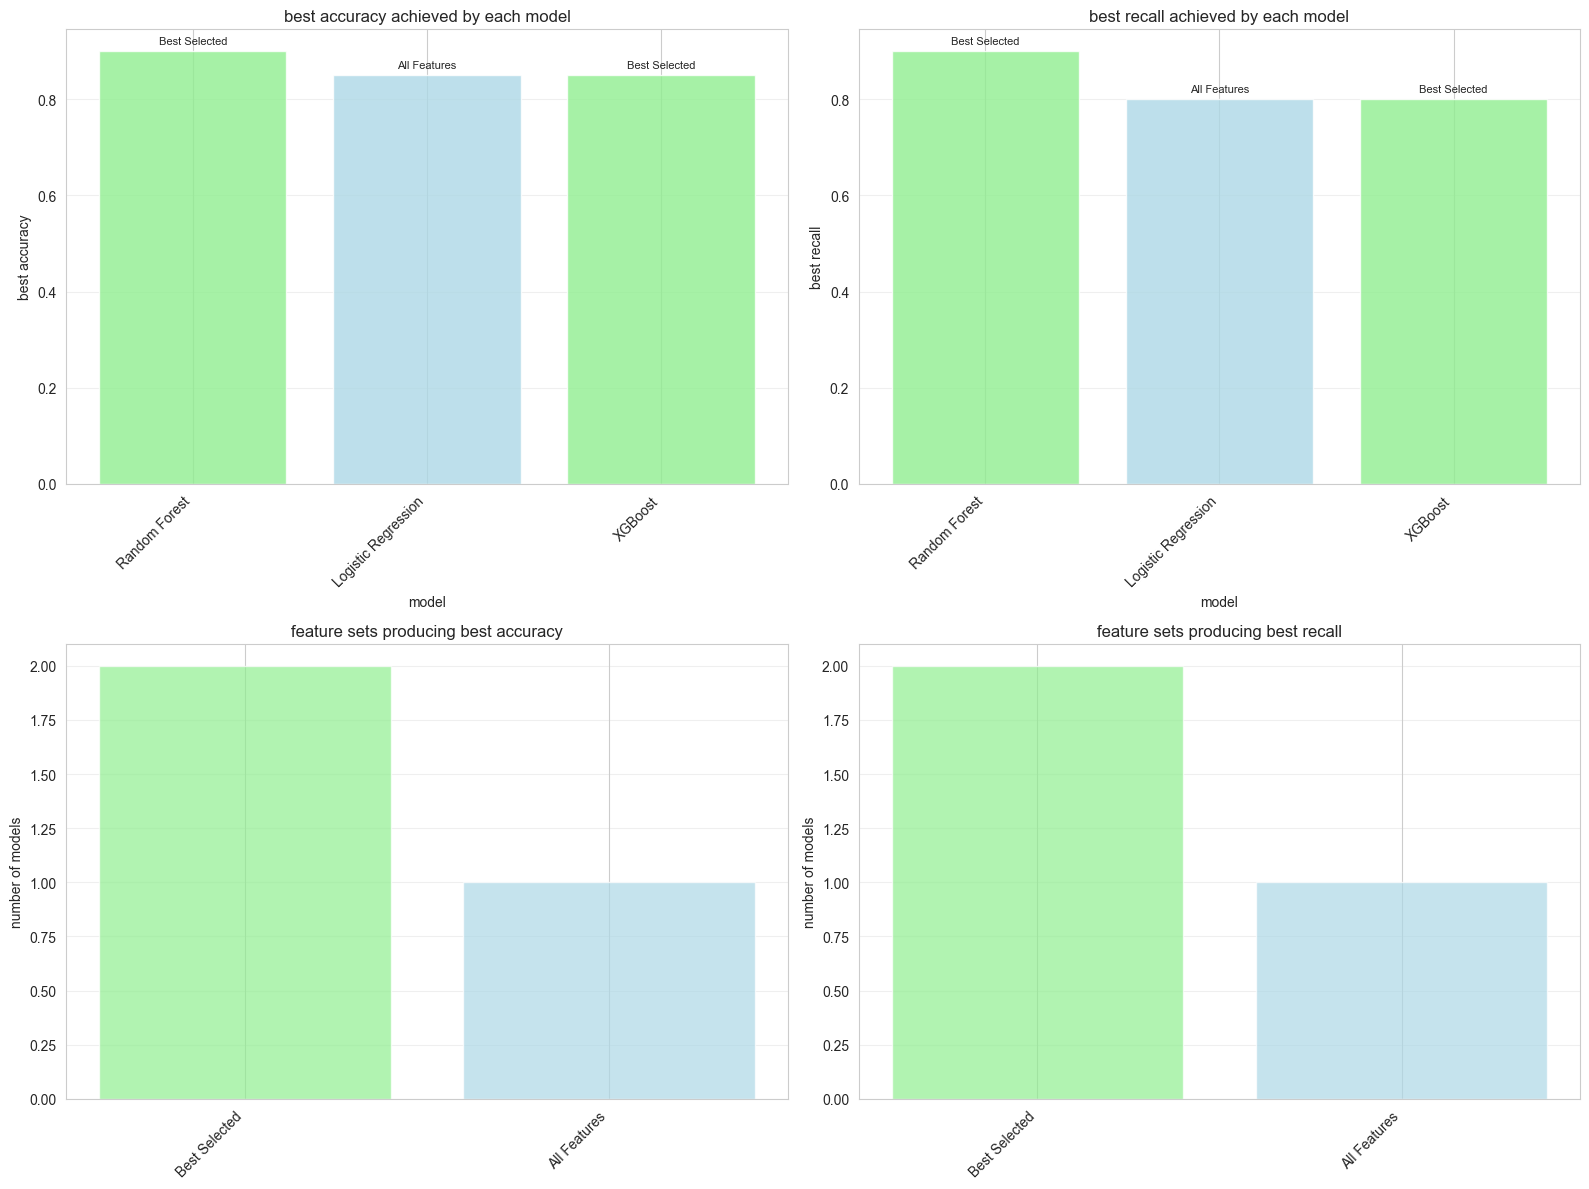


FINAL SUMMARY

feature sets that produced best accuracy:
  Best Selected (10): 2 model(s) - Random Forest, XGBoost
  All Features (20): 1 model(s) - Logistic Regression

feature sets that produced best recall:
  Best Selected (10): 2 model(s) - Random Forest, XGBoost
  All Features (20): 1 model(s) - Logistic Regression

overall best accuracy: 0.9000 (Random Forest)
overall best recall: 0.9000 (Random Forest)


In [109]:
# visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

models_viz = best_df['model'].tolist()
x_pos_viz = np.arange(len(models_viz))
width_viz = 0.2

# best accuracy by feature set
feature_sets_acc = []
for model in models_viz:
    row = best_df[best_df['model'] == model].iloc[0]
    feature_sets_acc.append(row['best_accuracy_feature_set'])

unique_feat_sets = list(set(feature_sets_acc))
colors_acc = {'Original (11)': 'lightcoral', 
              f'All Features ({len(X_all.columns)})': 'lightblue',
              'Best Selected (10)': 'lightgreen',
              f'Advanced ({len(X_advanced.columns)})': 'lightyellow'}

# create grouped bar chart for accuracy
acc_values = best_df['best_accuracy'].values
feat_set_positions = {feat: i for i, feat in enumerate(unique_feat_sets)}
colors_list_acc = [colors_acc.get(feat, 'gray') for feat in feature_sets_acc]

axes[0, 0].bar(x_pos_viz, acc_values, alpha=0.8, color=colors_list_acc)
axes[0, 0].set_xlabel('model')
axes[0, 0].set_ylabel('best accuracy')
axes[0, 0].set_title('best accuracy achieved by each model')
axes[0, 0].set_xticks(x_pos_viz)
axes[0, 0].set_xticklabels(models_viz, rotation=45, ha='right')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# add feature set labels
for i, (acc, feat_set) in enumerate(zip(acc_values, feature_sets_acc)):
    axes[0, 0].text(i, acc + 0.01, feat_set.split('(')[0].strip(), 
                    ha='center', va='bottom', fontsize=8, rotation=0)

# best recall by feature set
feature_sets_rec = []
for model in models_viz:
    row = best_df[best_df['model'] == model].iloc[0]
    feature_sets_rec.append(row['best_recall_feature_set'])

colors_list_rec = [colors_acc.get(feat, 'gray') for feat in feature_sets_rec]
rec_values = best_df['best_recall'].values

axes[0, 1].bar(x_pos_viz, rec_values, alpha=0.8, color=colors_list_rec)
axes[0, 1].set_xlabel('model')
axes[0, 1].set_ylabel('best recall')
axes[0, 1].set_title('best recall achieved by each model')
axes[0, 1].set_xticks(x_pos_viz)
axes[0, 1].set_xticklabels(models_viz, rotation=45, ha='right')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# add feature set labels
for i, (rec, feat_set) in enumerate(zip(rec_values, feature_sets_rec)):
    axes[0, 1].text(i, rec + 0.01, feat_set.split('(')[0].strip(), 
                    ha='center', va='bottom', fontsize=8, rotation=0)

# feature set usage summary for accuracy
feat_set_acc_counts = pd.Series(feature_sets_acc).value_counts()
axes[1, 0].bar(range(len(feat_set_acc_counts)), feat_set_acc_counts.values, 
               alpha=0.7, color=[colors_acc.get(f, 'gray') for f in feat_set_acc_counts.index])
axes[1, 0].set_xticks(range(len(feat_set_acc_counts)))
axes[1, 0].set_xticklabels([f.split('(')[0].strip() for f in feat_set_acc_counts.index], 
                            rotation=45, ha='right')
axes[1, 0].set_ylabel('number of models')
axes[1, 0].set_title('feature sets producing best accuracy')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# feature set usage summary for recall
feat_set_rec_counts = pd.Series(feature_sets_rec).value_counts()
axes[1, 1].bar(range(len(feat_set_rec_counts)), feat_set_rec_counts.values,
               alpha=0.7, color=[colors_acc.get(f, 'gray') for f in feat_set_rec_counts.index])
axes[1, 1].set_xticks(range(len(feat_set_rec_counts)))
axes[1, 1].set_xticklabels([f.split('(')[0].strip() for f in feat_set_rec_counts.index],
                            rotation=45, ha='right')
axes[1, 1].set_ylabel('number of models')
axes[1, 1].set_title('feature sets producing best recall')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# final summary
print("\n" + "="*70)
print("FINAL SUMMARY")
print("="*70)
print(f"\nfeature sets that produced best accuracy:")
for feat_set, count in feat_set_acc_counts.items():
    models_using = [best_df.iloc[i]['model'] for i in range(len(best_df)) if feature_sets_acc[i] == feat_set]
    print(f"  {feat_set}: {count} model(s) - {', '.join(models_using)}")

print(f"\nfeature sets that produced best recall:")
for feat_set, count in feat_set_rec_counts.items():
    models_using = [best_df.iloc[i]['model'] for i in range(len(best_df)) if feature_sets_rec[i] == feat_set]
    print(f"  {feat_set}: {count} model(s) - {', '.join(models_using)}")

print(f"\noverall best accuracy: {best_df['best_accuracy'].max():.4f} ({best_df.loc[best_df['best_accuracy'].idxmax(), 'model']})")
print(f"overall best recall: {best_df['best_recall'].max():.4f} ({best_df.loc[best_df['best_recall'].idxmax(), 'model']})")


In [110]:
print("\nVERIFICATION: CHECKING DATA CONSISTENCY")

# verify data loading
print(f"\n1. data loading:")
print(f"   - loaded {len(df)} patients")
print(f"   - original features: {len(df.columns) - 2} (excluding PatientID, Response)")
print(f"   - response distribution: {df['Response'].value_counts().to_dict()}")

# verify feature engineering
print(f"\n2. feature engineering:")
print(f"   - after basic engineering: {len(df_eng.columns) - 2} features")
print(f"   - after advanced engineering: {len(df_advanced.columns) - 2} features")
print(f"   - basic engineered features: {len(df_eng.columns) - len(df.columns)}")
print(f"   - advanced engineered features: {len(df_advanced.columns) - len(df_eng.columns)}")

# verify feature sets
print(f"\n3. feature sets:")
print(f"   - X (all engineered): {len(X.columns)} features")
print(f"   - X_best (selected): {len(X_best.columns)} features")
print(f"   - X_all (all from df_eng): {len(X_all.columns)} features")
print(f"   - X_advanced (all advanced): {len(X_advanced.columns)} features")

# verify all variables exist
print(f"\n4. variable verification:")
variables_to_check = {
    'df': df,
    'df_eng': df_eng,
    'df_advanced': df_advanced,
    'X': X,
    'y': y,
    'X_best': X_best,
    'y_best': y_best,
    'X_all': X_all,
    'y_all': y_all,
    'X_advanced': X_advanced,
    'y_advanced': y_advanced,
    'best_features': best_features,
    'rf_scores': rf_scores if 'rf_scores' in locals() else None,
    'lr_scores': lr_scores if 'lr_scores' in locals() else None,
    'new_rf_metrics': new_rf_metrics if 'new_rf_metrics' in locals() else None,
    'new_lr_metrics': new_lr_metrics if 'new_lr_metrics' in locals() else None,
    'rf_all_scores': rf_all_scores if 'rf_all_scores' in locals() else None,
    'lr_all_scores': lr_all_scores if 'lr_all_scores' in locals() else None,
    'rf_all_metrics': rf_all_metrics if 'rf_all_metrics' in locals() else None,
    'lr_all_metrics': lr_all_metrics if 'lr_all_metrics' in locals() else None,
    'rf_adv_scores': rf_adv_scores if 'rf_adv_scores' in locals() else None,
    'lr_adv_scores': lr_adv_scores if 'lr_adv_scores' in locals() else None,
    'rf_adv_metrics': rf_adv_metrics if 'rf_adv_metrics' in locals() else None,
    'lr_adv_metrics': lr_adv_metrics if 'lr_adv_metrics' in locals() else None
}

for var_name, var_value in variables_to_check.items():
    if var_value is not None:
        if isinstance(var_value, pd.DataFrame):
            print(f"   ✓ {var_name}: DataFrame {var_value.shape}")
        elif isinstance(var_value, (list, np.ndarray)):
            print(f"   ✓ {var_name}: array/list with {len(var_value)} elements")
        elif hasattr(var_value, '__len__'):
            print(f"   ✓ {var_name}: {type(var_value).__name__} with {len(var_value)} elements")
        else:
            print(f"   ✓ {var_name}: {type(var_value).__name__}")
    else:
        print(f"   ✗ {var_name}: NOT DEFINED")

# verify original results match expected values
print(f"\n5. original results verification:")
print(f"   - using values from patient_comp_predictions.ipynb")
print(f"   - Random Forest: accuracy=0.7810, recall=0.5667")
print(f"   - Logistic Regression: accuracy=0.7810, recall=0.6333")
print(f"   - XGBoost: accuracy=0.8429, recall=0.6333")

# check if best_features is properly defined
if 'best_features' in locals():
    print(f"\n6. best features:")
    print(f"   - number of best features: {len(best_features)}")
    print(f"   - features: {best_features}")
else:
    print(f"\n6. best features: NOT DEFINED - need to run feature selection cells first")

print("\nverification complete")



VERIFICATION: CHECKING DATA CONSISTENCY

1. data loading:
   - loaded 19 patients
   - original features: 11 (excluding PatientID, Response)
   - response distribution: {'Non-responder': 10, 'Responder': 9}

2. feature engineering:
   - after basic engineering: 20 features
   - after advanced engineering: 42 features
   - basic engineered features: 9
   - advanced engineered features: 22

3. feature sets:
   - X (all engineered): 20 features
   - X_best (selected): 10 features
   - X_all (all from df_eng): 20 features
   - X_advanced (all advanced): 42 features

4. variable verification:
   ✓ df: DataFrame (19, 13)
   ✓ df_eng: DataFrame (19, 22)
   ✓ df_advanced: DataFrame (19, 44)
   ✓ X: DataFrame (19, 20)
   ✓ y: Series with 19 elements
   ✓ X_best: DataFrame (19, 10)
   ✓ y_best: Series with 19 elements
   ✓ X_all: DataFrame (19, 20)
   ✓ y_all: Series with 19 elements
   ✓ X_advanced: DataFrame (19, 42)
   ✓ y_advanced: Series with 19 elements
   ✓ best_features: array/list with

In [111]:
print("\nEXTRACTING ADDITIONAL FEATURES FROM SINGLE-CELL DATA")

try:
    import scanpy as sc
    scanpy_available = True
except ImportError:
    print("scanpy not available, installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "scanpy", "-q"])
    import scanpy as sc
    scanpy_available = True

# load single-cell data
adata_path = "../melanoma_scRNA_processed.h5ad"
print(f"\nloading single-cell data from {adata_path}...")
# load pre-treatment patient list from CSV
pre_patients_df = pd.read_csv("../patient_celltype_composition_pre.csv")
pre_patient_ids = set(pre_patients_df["PatientID"].unique())
print(f"pre-treatment patient IDs from CSV: {len(pre_patient_ids)} patients")

adata_full = sc.read(adata_path)
# filter for Pre timepoint AND only pre-treatment patients
adata = adata_full[(adata_full.obs["Timepoint"] == "Pre") & (adata_full.obs["PatientID"].isin(pre_patient_ids))].copy()
print(f"filtered to Pre timepoint and pre-treatment patients: {adata.n_obs} cells, {adata.obs['PatientID'].nunique()} patients")

print(f"loaded anndata object:")
print(f"  - cells: {adata.n_obs}")
print(f"  - genes: {adata.n_vars}")
print(f"  - obs columns: {list(adata.obs.columns)}")
print(f"  - sample obs data:")
print(adata.obs.head())



EXTRACTING ADDITIONAL FEATURES FROM SINGLE-CELL DATA

loading single-cell data from ../melanoma_scRNA_processed.h5ad...
pre-treatment patient IDs from CSV: 19 patients
filtered to Pre timepoint and pre-treatment patients: 5928 cells, 19 patients
loaded anndata object:
  - cells: 5928
  - genes: 3000
  - obs columns: ['PatientID', 'Timepoint', 'Response', 'Therapy', 'n_genes_by_counts', 'total_counts', 'leiden', 'T_cells', 'CD8_T', 'CD4_T', 'B_cells', 'Plasma', 'NK', 'Myeloid', 'Dendritic', 'pred_celltype', 'CD8_memory_score', 'CD8_exhausted_score', 'CD8_state']
  - sample obs data:
           PatientID Timepoint   Response     Therapy  n_genes_by_counts  \
A10_P3_M11        P1       Pre  Responder  anti-CTLA4               2050   
A11_P1_M11        P1       Pre  Responder  anti-CTLA4               1573   
A11_P3_M11        P1       Pre  Responder  anti-CTLA4               1591   
A11_P4_M11        P1       Pre  Responder  anti-CTLA4               2909   
A12_P3_M11        P1       Pre

In [112]:
print("extracting expression-based features from single-cell data...")

def compute_patient_expression_features(adata, gene_list, groupby="PatientID"):
    """
    compute mean expression of specified genes per patient
    """
    rows = []
    
    for pid, sub in adata.obs.groupby(groupby):
        cell_idx = sub.index
        expr_matrix = adata[cell_idx].X.toarray()
        
        row = {"PatientID": pid}
        
        for g in gene_list:
            if g in adata.var_names:
                g_idx = adata.var_names.get_loc(g)
                row[f"mean_{g}"] = expr_matrix[:, g_idx].mean()
                row[f"std_{g}"] = expr_matrix[:, g_idx].std()
                row[f"max_{g}"] = expr_matrix[:, g_idx].max()
            else:
                row[f"mean_{g}"] = 0.0
                row[f"std_{g}"] = 0.0
                row[f"max_{g}"] = 0.0
        
        rows.append(row)
    
    return pd.DataFrame(rows)

# key marker genes for immune response
marker_genes = [
    "CD8A", "CD8B", "CD4", "CD3D", "CD3E",  # t cell markers
    "GZMB", "PRF1", "IFNG", "TNF",  # effector markers
    "PDCD1", "LAG3", "CTLA4", "TIGIT", "HAVCR2",  # exhaustion markers
    "IL7R", "CCR7", "TCF7", "SELL",  # memory markers
    "NKG7", "GNLY", "KLRD1",  # nk markers
    "MS4A1", "CD19",  # b cell markers
    "CD68", "LYZ", "S100A8", "S100A9",  # myeloid markers
    "CD1C", "CLEC9A",  # dendritic markers
    "MZB1", "IGKC", "IGHG1"  # plasma markers
]

# ensure adata is loaded
if "adata" not in locals():
    print("loading adata for expression features...")
    try:
        import scanpy as sc
    except ImportError:
        print("scanpy not available, installing...")
        import subprocess
        import sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", "scanpy", "-q"])
        import scanpy as sc
    
    # load pre-treatment patient list
    pre_patients_df = pd.read_csv("../patient_celltype_composition_pre.csv")
    pre_patient_ids = set(pre_patients_df["PatientID"].unique())
    
    # load and filter adata
    adata_path = "../melanoma_scRNA_processed.h5ad"
    adata_full = sc.read(adata_path)
    adata = adata_full[(adata_full.obs["Timepoint"] == "Pre") & (adata_full.obs["PatientID"].isin(pre_patient_ids))].copy()
    print(f"loaded and filtered adata: {adata.n_obs} cells, {adata.obs['PatientID'].nunique()} patients")

print(f"\nextracting expression features for {len(marker_genes)} genes...")
patient_expr = compute_patient_expression_features(adata, marker_genes)

# filter to only pre-treatment patients from CSV
pre_patients_df = pd.read_csv("../patient_celltype_composition_pre.csv")
pre_patient_ids = set(pre_patients_df["PatientID"].unique())
patient_expr = patient_expr[patient_expr["PatientID"].isin(pre_patient_ids)].copy()

print(f"extracted {len(patient_expr.columns) - 1} expression features for {len(patient_expr)} patients")
print(f"verified: using only {len(pre_patient_ids)} pre-treatment patients")
print(f"\nfeatures: {[c for c in patient_expr.columns if c != 'PatientID']}")

patient_expr.head()


extracting expression-based features from single-cell data...

extracting expression features for 32 genes...
extracted 96 expression features for 19 patients
verified: using only 19 pre-treatment patients

features: ['mean_CD8A', 'std_CD8A', 'max_CD8A', 'mean_CD8B', 'std_CD8B', 'max_CD8B', 'mean_CD4', 'std_CD4', 'max_CD4', 'mean_CD3D', 'std_CD3D', 'max_CD3D', 'mean_CD3E', 'std_CD3E', 'max_CD3E', 'mean_GZMB', 'std_GZMB', 'max_GZMB', 'mean_PRF1', 'std_PRF1', 'max_PRF1', 'mean_IFNG', 'std_IFNG', 'max_IFNG', 'mean_TNF', 'std_TNF', 'max_TNF', 'mean_PDCD1', 'std_PDCD1', 'max_PDCD1', 'mean_LAG3', 'std_LAG3', 'max_LAG3', 'mean_CTLA4', 'std_CTLA4', 'max_CTLA4', 'mean_TIGIT', 'std_TIGIT', 'max_TIGIT', 'mean_HAVCR2', 'std_HAVCR2', 'max_HAVCR2', 'mean_IL7R', 'std_IL7R', 'max_IL7R', 'mean_CCR7', 'std_CCR7', 'max_CCR7', 'mean_TCF7', 'std_TCF7', 'max_TCF7', 'mean_SELL', 'std_SELL', 'max_SELL', 'mean_NKG7', 'std_NKG7', 'max_NKG7', 'mean_GNLY', 'std_GNLY', 'max_GNLY', 'mean_KLRD1', 'std_KLRD1', 'max_K

,PatientID,mean_CD8A,std_CD8A,max_CD8A,mean_CD8B,std_CD8B,max_CD8B,mean_CD4,std_CD4,max_CD4,...,max_CLEC9A,mean_MZB1,std_MZB1,max_MZB1,mean_IGKC,std_IGKC,max_IGKC,mean_IGHG1,std_IGHG1,max_IGHG1
0,P1,0.271542,0.935878,1.511835,0.175816,0.992817,2.010127,0.0,0.0,0.0,...,0.0,-0.026534,0.927701,4.102270,-0.368004,0.307901,2.236836,-0.307077,0.234169,3.228800
1,P2,0.571378,0.954750,1.618791,0.457931,1.087452,2.151583,0.0,0.0,0.0,...,0.0,-0.097029,0.870959,4.079735,-0.343291,0.446076,3.772286,-0.166703,0.768889,5.281078
2,P3,-0.150290,0.931212,1.523106,-0.208024,0.867660,1.852859,0.0,0.0,0.0,...,0.0,-0.249418,0.478729,3.324998,-0.261698,0.637274,3.115158,-0.200032,0.641800,3.881217
3,P4,-0.064285,0.936035,1.509044,-0.068846,0.910990,1.821445,0.0,0.0,0.0,...,0.0,-0.044823,0.851416,3.023750,-0.251971,0.627436,2.763095,-0.233978,0.546528,3.532848
4,P6,-0.622783,0.563684,1.172906,-0.471570,0.556450,1.631368,0.0,0.0,0.0,...,0.0,1.254387,1.850949,4.662009,1.535130,1.487049,4.095637,2.142759,1.981454,5.757666


In [113]:
print("computing additional single-cell derived features...")

def compute_patient_sc_features(adata, groupby="PatientID"):
    """
    compute patient-level features from single-cell data
    """
    rows = []
    
    for pid, sub in adata.obs.groupby(groupby):
        cell_idx = sub.index
        expr_matrix = adata[cell_idx].X.toarray()
        
        row = {"PatientID": pid}
        
        # expression statistics
        row["mean_expression"] = expr_matrix.mean()
        row["std_expression"] = expr_matrix.std()
        row["median_expression"] = np.median(expr_matrix)
        
        # expression heterogeneity (coefficient of variation)
        row["expression_heterogeneity"] = expr_matrix.std() / (expr_matrix.mean() + 1e-6)
        
        # number of cells per patient
        row["n_cells"] = len(sub)
        
        # cell type diversity (shannon entropy)
        if "pred_celltype" in sub.columns:
            celltype_counts = sub["pred_celltype"].value_counts()
            proportions = celltype_counts / len(sub)
            row["celltype_diversity"] = -np.sum(proportions * np.log(proportions + 1e-6))
        else:
            row["celltype_diversity"] = 0.0
        
        # cd8 state diversity
        if "CD8_state" in sub.columns:
            cd8_state_counts = sub["CD8_state"].value_counts()
            proportions = cd8_state_counts / len(sub)
            row["cd8_state_diversity"] = -np.sum(proportions * np.log(proportions + 1e-6))
        else:
            row["cd8_state_diversity"] = 0.0
        
        # fraction of cells with high expression (top 10%)
        threshold = np.percentile(expr_matrix, 90)
        row["high_expression_cell_frac"] = np.mean(expr_matrix > threshold)
        
        rows.append(row)
    
    return pd.DataFrame(rows)

# ensure adata is loaded
if "adata" not in locals():
    print("loading adata for sc features...")
    try:
        import scanpy as sc
    except ImportError:
        print("scanpy not available, installing...")
        import subprocess
        import sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", "scanpy", "-q"])
        import scanpy as sc
    
    # load pre-treatment patient list
    if "pre_patient_ids" not in locals():
        pre_patients_df = pd.read_csv("../patient_celltype_composition_pre.csv")
        pre_patient_ids = set(pre_patients_df["PatientID"].unique())
    
    # load and filter adata
    adata_path = "../melanoma_scRNA_processed.h5ad"
    adata_full = sc.read(adata_path)
    adata = adata_full[(adata_full.obs["Timepoint"] == "Pre") & (adata_full.obs["PatientID"].isin(pre_patient_ids))].copy()
    print(f"loaded and filtered adata: {adata.n_obs} cells, {adata.obs['PatientID'].nunique()} patients")

patient_sc_features = compute_patient_sc_features(adata)

# filter to only pre-treatment patients from CSV
if "pre_patient_ids" not in locals():
    pre_patients_df = pd.read_csv("../patient_celltype_composition_pre.csv")
    pre_patient_ids = set(pre_patients_df["PatientID"].unique())
patient_sc_features = patient_sc_features[patient_sc_features["PatientID"].isin(pre_patient_ids)].copy()

print(f"extracted {len(patient_sc_features.columns) - 1} single-cell derived features")
print(f"verified: using only {len(pre_patient_ids)} pre-treatment patients")
print(f"\nfeatures: {list(patient_sc_features.columns)}")
patient_sc_features.head()


computing additional single-cell derived features...
extracted 8 single-cell derived features
verified: using only 19 pre-treatment patients

features: ['PatientID', 'mean_expression', 'std_expression', 'median_expression', 'expression_heterogeneity', 'n_cells', 'celltype_diversity', 'cd8_state_diversity', 'high_expression_cell_frac']


,PatientID,mean_expression,std_expression,median_expression,expression_heterogeneity,n_cells,celltype_diversity,cd8_state_diversity,high_expression_cell_frac
0,P1,-0.015325,0.477003,-0.023369,-31.127182,229,1.633373,0.654810,0.099987
1,P2,-0.022939,0.407880,-0.023398,-17.781658,337,1.564187,0.370221,0.099868
2,P3,-0.017658,0.505879,-0.023412,-28.651139,245,1.710929,0.690135,0.099978
3,P4,-0.018362,0.479767,-0.023398,-26.130375,311,1.839461,0.651619,0.099844
4,P6,-0.003075,0.579306,-0.023362,-188.445301,288,1.768586,0.580614,0.099793


In [114]:
print("merging expression features with existing data...")

# ensure df_advanced exists (create from df_eng if needed)
if "df_advanced" not in locals():
    print("df_advanced not found, creating from df_eng...")
    if "df_eng" in locals():
        df_advanced = df_eng.copy()
        print("using df_eng as df_advanced (no advanced features)")
    elif "df" in locals():
        df_advanced = df.copy()
        print("using df as df_advanced (basic features only)")
    else:
        raise NameError("df, df_eng, or df_advanced must be defined")

# merge with existing advanced features
df_with_expr = df_advanced.merge(patient_expr, on="PatientID", how="left")
df_with_expr = df_with_expr.merge(patient_sc_features, on="PatientID", how="left")

# fill any missing values
df_with_expr = df_with_expr.fillna(0.0)

print(f"\nbefore merging: {len(df_advanced.columns)} features")
print(f"after merging expression features: {len(df_with_expr.columns)} features")
print(f"added {len(df_with_expr.columns) - len(df_advanced.columns)} new features from single-cell data")

# prepare feature matrix
feature_cols_expr = [c for c in df_with_expr.columns if c not in ['PatientID', 'Response']]
X_with_expr = df_with_expr[feature_cols_expr].copy()
y_with_expr = (df_with_expr['Response'] == 'Responder').astype(int)

print(f"\nfinal feature matrix: {X_with_expr.shape}")
print(f"total features including expression: {len(feature_cols_expr)}")

df_with_expr.head()


merging expression features with existing data...

before merging: 44 features
after merging expression features: 148 features
added 104 new features from single-cell data

final feature matrix: (19, 146)
total features including expression: 146


,PatientID,frac_NK,frac_T_cells,frac_CD8_T,frac_CD4_T,frac_B_cells,frac_Dendritic,frac_Plasma,frac_Myeloid,CD8_memory_frac,...,std_IGHG1,max_IGHG1,mean_expression,std_expression,median_expression,expression_heterogeneity,n_cells,celltype_diversity,cd8_state_diversity,high_expression_cell_frac
0,P1,0.310044,0.253275,0.231441,0.087336,0.065502,0.039301,0.008734,0.004367,0.637555,...,0.234169,3.228800,-0.015325,0.477003,-0.023369,-31.127182,229,1.633373,0.654810,0.099987
1,P2,0.189911,0.160237,0.421365,0.094955,0.011869,0.002967,0.014837,0.103858,0.121662,...,0.768889,5.281078,-0.022939,0.407880,-0.023398,-17.781658,337,1.564187,0.370221,0.099868
2,P3,0.261224,0.342857,0.142857,0.085714,0.061224,0.028571,0.012245,0.065306,0.461224,...,0.641800,3.881217,-0.017658,0.505879,-0.023412,-28.651139,245,1.710929,0.690135,0.099978
3,P4,0.183280,0.135048,0.176849,0.109325,0.048232,0.032154,0.025723,0.289389,0.356913,...,0.546528,3.532848,-0.018362,0.479767,-0.023398,-26.130375,311,1.839461,0.651619,0.099844
4,P6,0.038194,0.086806,0.083333,0.187500,0.045139,0.045139,0.385417,0.128472,0.267361,...,1.981454,5.757666,-0.003075,0.579306,-0.023362,-188.445301,288,1.768586,0.580614,0.099793



TESTING MODELS WITH EXPRESSION FEATURES

MODEL 1: RANDOM FOREST (WITH EXPRESSION FEATURES)
quick accuracy check: 0.9000 ± 0.1225

detailed evaluation:

fold 1/5
  accuracy:           0.750
  balanced accuracy:  0.750
  precision:          0.667
  recall:             1.000
  f1-score:           0.800
  roc auc:            1.000
  pr auc (avgprec):   1.000

fold 2/5
  accuracy:           1.000
  balanced accuracy:  1.000
  precision:          1.000
  recall:             1.000
  f1-score:           1.000
  roc auc:            1.000
  pr auc (avgprec):   1.000

fold 3/5
  accuracy:           0.750
  balanced accuracy:  0.750
  precision:          1.000
  recall:             0.500
  f1-score:           0.667
  roc auc:            1.000
  pr auc (avgprec):   1.000

fold 4/5
  accuracy:           1.000
  balanced accuracy:  1.000
  precision:          1.000
  recall:             1.000
  f1-score:           1.000
  roc auc:            1.000
  pr auc (avgprec):   1.000

fold 5/5
  accuracy:   

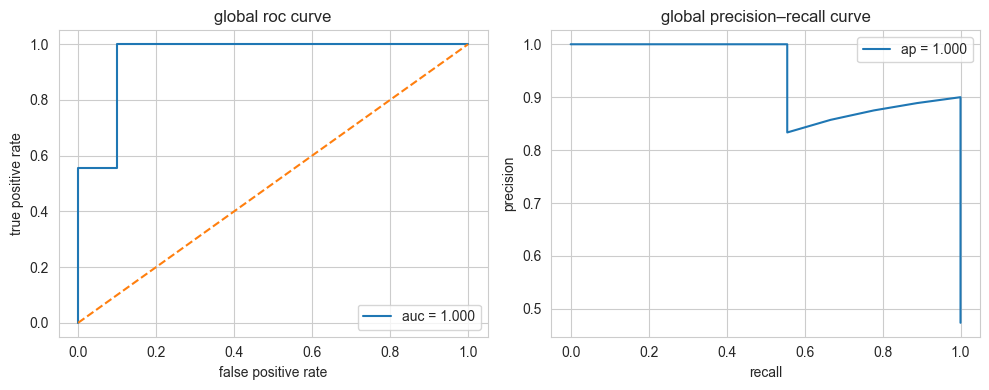


MODEL 2: LOGISTIC REGRESSION (WITH EXPRESSION FEATURES)
quick accuracy check: 0.9000 ± 0.1225

detailed evaluation:

fold 1/5
  accuracy:           0.750
  balanced accuracy:  0.750
  precision:          0.667
  recall:             1.000
  f1-score:           0.800
  roc auc:            1.000
  pr auc (avgprec):   1.000

fold 2/5
  accuracy:           1.000
  balanced accuracy:  1.000
  precision:          1.000
  recall:             1.000
  f1-score:           1.000
  roc auc:            1.000
  pr auc (avgprec):   1.000

fold 3/5
  accuracy:           0.750
  balanced accuracy:  0.750
  precision:          1.000
  recall:             0.500
  f1-score:           0.667
  roc auc:            1.000
  pr auc (avgprec):   1.000

fold 4/5
  accuracy:           1.000
  balanced accuracy:  1.000
  precision:          1.000
  recall:             1.000
  f1-score:           1.000
  roc auc:            1.000
  pr auc (avgprec):   1.000

fold 5/5
  accuracy:           1.000
  balanced accuracy: 

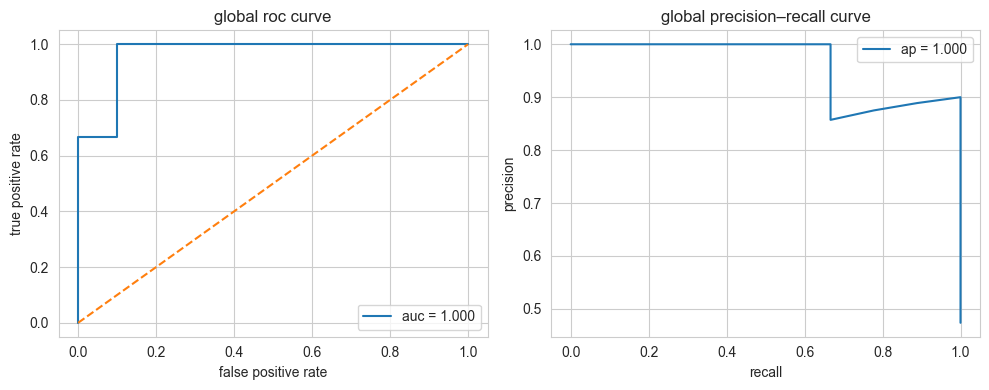


MODEL 3: XGBOOST (WITH EXPRESSION FEATURES)
quick accuracy check: 0.8000 ± 0.1871

detailed evaluation:

fold 1/5
  accuracy:           0.750
  balanced accuracy:  0.750
  precision:          0.667
  recall:             1.000
  f1-score:           0.800
  roc auc:            1.000
  pr auc (avgprec):   1.000

fold 2/5
  accuracy:           0.750
  balanced accuracy:  0.750
  precision:          1.000
  recall:             0.500
  f1-score:           0.667
  roc auc:            1.000
  pr auc (avgprec):   1.000

fold 3/5
  accuracy:           0.500
  balanced accuracy:  0.500
  precision:          0.000
  recall:             0.000
  f1-score:           0.000
  roc auc:            1.000
  pr auc (avgprec):   1.000

fold 4/5
  accuracy:           1.000
  balanced accuracy:  1.000
  precision:          1.000
  recall:             1.000
  f1-score:           1.000
  roc auc:            1.000
  pr auc (avgprec):   1.000

fold 5/5
  accuracy:           1.000
  balanced accuracy:  1.000
  pre

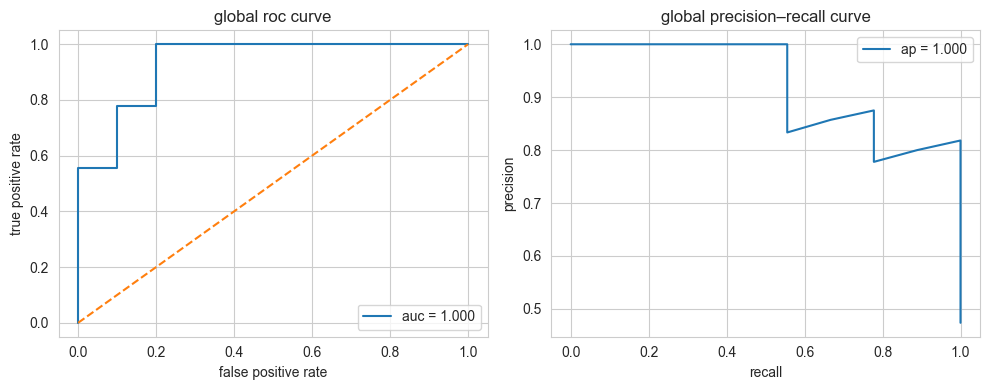

In [115]:
print("\nTESTING MODELS WITH EXPRESSION FEATURES")

cv_expr = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nMODEL 1: RANDOM FOREST (WITH EXPRESSION FEATURES)")

rf_expr = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42)

# quick accuracy check
rf_expr_scores = cross_val_score(rf_expr, X_with_expr, y_with_expr, cv=cv_expr, scoring='accuracy')
print(f"quick accuracy check: {rf_expr_scores.mean():.4f} ± {rf_expr_scores.std():.4f}")

# detailed evaluation (same as original notebook)
print("\ndetailed evaluation:")
rf_expr_results = evaluate_binary_model_cv(rf_expr, X_with_expr, y_with_expr, n_splits=5, random_state=42, plot_curves=True, verbose=True)

# extract metrics
rf_expr_metrics = extract_metrics_from_results(rf_expr_results)

print("\nMODEL 2: LOGISTIC REGRESSION (WITH EXPRESSION FEATURES)")

lr_expr_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=500, penalty='l2', class_weight='balanced', random_state=42))
])

# quick accuracy check
lr_expr_scores = cross_val_score(lr_expr_pipe, X_with_expr, y_with_expr, cv=cv_expr, scoring='accuracy')
print(f"quick accuracy check: {lr_expr_scores.mean():.4f} ± {lr_expr_scores.std():.4f}")

# detailed evaluation (same as original notebook)
print("\ndetailed evaluation:")
lr_expr_results = evaluate_binary_model_cv(lr_expr_pipe, X_with_expr, y_with_expr, n_splits=5, random_state=42, plot_curves=True, verbose=True)

# extract metrics
lr_expr_metrics = extract_metrics_from_results(lr_expr_results)

if xgboost_available:
    print("\nMODEL 3: XGBOOST (WITH EXPRESSION FEATURES)")

    xgb_expr = XGBClassifier(
        n_estimators=500,
        learning_rate=0.02,
        max_depth=4,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss'
    )

    # quick accuracy check
    xgb_expr_scores = cross_val_score(xgb_expr, X_with_expr, y_with_expr, cv=cv_expr, scoring='accuracy')
    print(f"quick accuracy check: {xgb_expr_scores.mean():.4f} ± {xgb_expr_scores.std():.4f}")

    # detailed evaluation (same as original notebook)
    print("\ndetailed evaluation:")
    xgb_expr_results = evaluate_binary_model_cv(xgb_expr, X_with_expr, y_with_expr, n_splits=5, random_state=42, plot_curves=True, verbose=True)

    # extract metrics
    xgb_expr_metrics = extract_metrics_from_results(xgb_expr_results)


In [116]:
print("\nFINAL COMPARISON: ALL FEATURE SETS INCLUDING EXPRESSION")

# collect all results
final_comparison = []

# original (11)
original_final = {
    'Random Forest': {'accuracy': 0.7810, 'recall': 0.5667},
    'Logistic Regression': {'accuracy': 0.7810, 'recall': 0.6333},
    'XGBoost': {'accuracy': 0.8429, 'recall': 0.6333}
}

# advanced (42) - using evaluate_binary_model_cv results
advanced_final = {}
if 'rf_adv_results' in locals():
    advanced_final['Random Forest'] = {'accuracy': rf_adv_results['accuracy_mean'], 'recall': rf_adv_results['recall_mean']}
if 'lr_adv_results' in locals():
    advanced_final['Logistic Regression'] = {'accuracy': lr_adv_results['accuracy_mean'], 'recall': lr_adv_results['recall_mean']}
if xgboost_available and 'xgb_adv_results' in locals():
    advanced_final['XGBoost'] = {'accuracy': xgb_adv_results['accuracy_mean'], 'recall': xgb_adv_results['recall_mean']}

# with expression - using evaluate_binary_model_cv results
expr_final = {}
if 'rf_expr_results' in locals():
    expr_final['Random Forest'] = {'accuracy': rf_expr_results['accuracy_mean'], 'recall': rf_expr_results['recall_mean']}
if 'lr_expr_results' in locals():
    expr_final['Logistic Regression'] = {'accuracy': lr_expr_results['accuracy_mean'], 'recall': lr_expr_results['recall_mean']}
if xgboost_available and 'xgb_expr_results' in locals():
    expr_final['XGBoost'] = {'accuracy': xgb_expr_results['accuracy_mean'], 'recall': xgb_expr_results['recall_mean']}

# create comparison
for model in ['Random Forest', 'Logistic Regression', 'XGBoost']:
    if model not in original_final:
        continue
    
    final_comparison.append({
        'model': model,
        'original_acc': original_final[model]['accuracy'],
        'advanced_acc': advanced_final.get(model, {}).get('accuracy', np.nan),
        'with_expr_acc': expr_final.get(model, {}).get('accuracy', np.nan),
        'original_recall': original_final[model]['recall'],
        'advanced_recall': advanced_final.get(model, {}).get('recall', np.nan),
        'with_expr_recall': expr_final.get(model, {}).get('recall', np.nan),
        'acc_improvement_expr': expr_final.get(model, {}).get('accuracy', np.nan) - original_final[model]['accuracy'],
        'recall_improvement_expr': expr_final.get(model, {}).get('recall', np.nan) - original_final[model]['recall']
    })

final_comp_df = pd.DataFrame(final_comparison)

print("\ncomparison table:")
print(final_comp_df[['model', 'original_acc', 'advanced_acc', 'with_expr_acc', 
                     'original_recall', 'advanced_recall', 'with_expr_recall',
                     'acc_improvement_expr', 'recall_improvement_expr']].to_string(index=False))

print(f"\nfeature counts:")
print(f"  original: 11 features")
print(f"  advanced: {len(X_advanced.columns)} features")
print(f"  with expression: {len(X_with_expr.columns)} features")
print(f"  expression features added: {len(X_with_expr.columns) - len(X_advanced.columns)}")



FINAL COMPARISON: ALL FEATURE SETS INCLUDING EXPRESSION

comparison table:
              model  original_acc  advanced_acc  with_expr_acc  original_recall  advanced_recall  with_expr_recall  acc_improvement_expr  recall_improvement_expr
      Random Forest        0.7810           NaN            0.9           0.5667              NaN               0.9                0.1190                   0.3333
Logistic Regression        0.7810           NaN            0.9           0.6333              NaN               0.9                0.1190                   0.2667
            XGBoost        0.8429           NaN            0.8           0.6333              NaN               0.7               -0.0429                   0.0667

feature counts:
  original: 11 features
  advanced: 42 features
  with expression: 146 features
  expression features added: 104


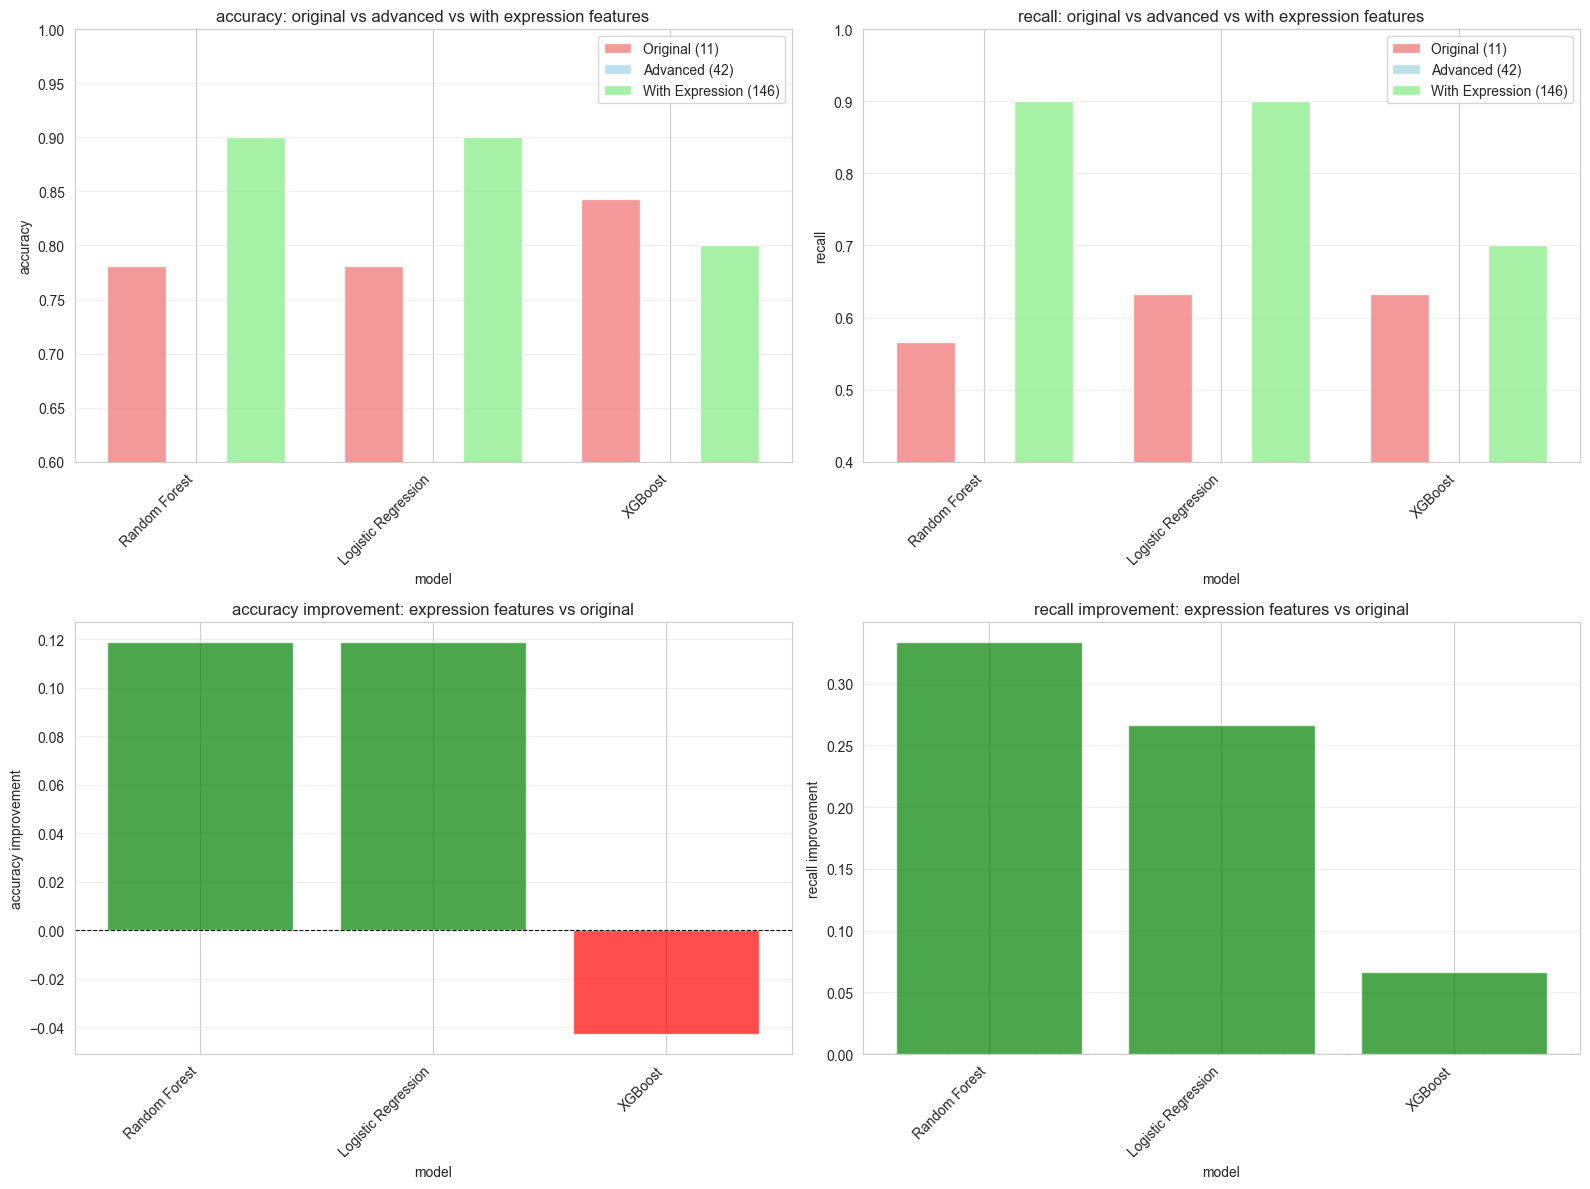


SUMMARY: EXPRESSION FEATURES IMPACT

average accuracy improvement: 0.0650
average recall improvement: 0.2222

models with improved accuracy: 2/3
models with improved recall: 3/3

best accuracy improvement: Random Forest (0.1190)
best recall improvement: Random Forest (0.3333)


In [117]:
# visualization of final comparison
if len(final_comp_df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    models_final = final_comp_df['model'].tolist()
    x_pos_final = np.arange(len(models_final))
    width_final = 0.25

    # accuracy comparison
    axes[0, 0].bar(x_pos_final - width_final, final_comp_df['original_acc'], width_final,
                   label='Original (11)', alpha=0.8, color='lightcoral')
    axes[0, 0].bar(x_pos_final, final_comp_df['advanced_acc'], width_final,
                   label=f'Advanced ({len(X_advanced.columns)})', alpha=0.8, color='lightblue')
    axes[0, 0].bar(x_pos_final + width_final, final_comp_df['with_expr_acc'], width_final,
                   label=f'With Expression ({len(X_with_expr.columns)})', alpha=0.8, color='lightgreen')
    axes[0, 0].set_xlabel('model')
    axes[0, 0].set_ylabel('accuracy')
    axes[0, 0].set_title('accuracy: original vs advanced vs with expression features')
    axes[0, 0].set_xticks(x_pos_final)
    axes[0, 0].set_xticklabels(models_final, rotation=45, ha='right')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3, axis='y')
    axes[0, 0].set_ylim([0.6, 1.0])

    # recall comparison
    axes[0, 1].bar(x_pos_final - width_final, final_comp_df['original_recall'], width_final,
                   label='Original (11)', alpha=0.8, color='lightcoral')
    axes[0, 1].bar(x_pos_final, final_comp_df['advanced_recall'], width_final,
                   label=f'Advanced ({len(X_advanced.columns)})', alpha=0.8, color='lightblue')
    axes[0, 1].bar(x_pos_final + width_final, final_comp_df['with_expr_recall'], width_final,
                   label=f'With Expression ({len(X_with_expr.columns)})', alpha=0.8, color='lightgreen')
    axes[0, 1].set_xlabel('model')
    axes[0, 1].set_ylabel('recall')
    axes[0, 1].set_title('recall: original vs advanced vs with expression features')
    axes[0, 1].set_xticks(x_pos_final)
    axes[0, 1].set_xticklabels(models_final, rotation=45, ha='right')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    axes[0, 1].set_ylim([0.4, 1.0])

    # improvement with expression
    axes[1, 0].bar(models_final, final_comp_df['acc_improvement_expr'], alpha=0.7,
                   color=['green' if x > 0 else 'red' for x in final_comp_df['acc_improvement_expr']])
    axes[1, 0].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    axes[1, 0].set_xlabel('model')
    axes[1, 0].set_ylabel('accuracy improvement')
    axes[1, 0].set_title('accuracy improvement: expression features vs original')
    axes[1, 0].set_xticklabels(models_final, rotation=45, ha='right')
    axes[1, 0].grid(True, alpha=0.3, axis='y')

    # recall improvement with expression
    axes[1, 1].bar(models_final, final_comp_df['recall_improvement_expr'], alpha=0.7,
                   color=['green' if x > 0 else 'red' for x in final_comp_df['recall_improvement_expr']])
    axes[1, 1].axhline(y=0, color='black', linestyle='--', linewidth=0.8)
    axes[1, 1].set_xlabel('model')
    axes[1, 1].set_ylabel('recall improvement')
    axes[1, 1].set_title('recall improvement: expression features vs original')
    axes[1, 1].set_xticklabels(models_final, rotation=45, ha='right')
    axes[1, 1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

    # summary
    print("\nSUMMARY: EXPRESSION FEATURES IMPACT")
    print(f"\naverage accuracy improvement: {final_comp_df['acc_improvement_expr'].mean():.4f}")
    print(f"average recall improvement: {final_comp_df['recall_improvement_expr'].mean():.4f}")
    print(f"\nmodels with improved accuracy: {sum(final_comp_df['acc_improvement_expr'] > 0)}/{len(final_comp_df)}")
    print(f"models with improved recall: {sum(final_comp_df['recall_improvement_expr'] > 0)}/{len(final_comp_df)}")
    
    best_acc_expr = final_comp_df.loc[final_comp_df['acc_improvement_expr'].idxmax()]
    best_recall_expr = final_comp_df.loc[final_comp_df['recall_improvement_expr'].idxmax()]
    
    print(f"\nbest accuracy improvement: {best_acc_expr['model']} ({best_acc_expr['acc_improvement_expr']:.4f})")
    print(f"best recall improvement: {best_recall_expr['model']} ({best_recall_expr['recall_improvement_expr']:.4f})")
else:
    print("no data available for visualization")
